In [36]:
from ensembles import VanillaEnsemble
from datasets import make_dataset, make_cross_validation_dataset,generate_sinoid_and_spline
from plot import plot_dataset, plot_prediction, train_and_plot, plot_error
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
from evaluation import evaluate_model
import tensorflow as tf

from tqdm import tqdm


# Explanation



Showing the efficiency of two estimators, comparing to a vanialla Neural Network.

All Estimators are built in tensorflow (1.4 [*]) and are based on the same parent object (ToDo: Make this more beautiful and readable). Code can be found in /estimators.

GaussianLossEstimator [1], in which $\mu$ and $\sigma^2$ are estimated directly by using a gaussian cost function $-1/2 ln [\sigma^2(x_i)] - \frac{[y-\hat{y}]^2}{2\sigma^2(x_i)} $. In practice, this means separate output nodes have been added for both mean and variance, with corrensponding final layers. To ensure positive $\sigma^2$, a softmax function is applied according to [2]. The derivatives used for the backwards pass update can be found in [1], thanks to Tensorflows Automatic Differentiation, the author was spared implementing a working function of this [4].

GaussianLearningRateEstimator, which is a GaussianLossEstimator in which the predicted $\sigma$ is used to scale the learning rate for each sample. This approach hasn't been found in a [arguable somewhat shallow] literature review. It's too early to claim novelty, but it is fun to work with!

For both models, a minimum variance is returned if the variance goes below a certain threshold to (try to) avoid numerical instabilities


No Regularisation has been added, thus quite a bit of overfitting occurs.







# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), so no distribution over parameters


# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is on-line, i.e. each sample is fed into the network on a singular basis (Stochastic gradient descent with batch size 1)

The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list)


# Problems/ToDo
Weirdly, the standard GaussianLossEstimator tends to fall into numerical instabilities (see e.g. seed #forgottowritedowntheseedandIfeelbad (1011???))

Overfitting is locally SEVERE sometimes (e.g. seed 43). Why.

Adding SOME Regularisation might be cool: The learning rate thing looks like a perfect fit for early stopping

Hyperparameters need to be tuned

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)

Learningrate scaling in GaussianLearningRateEstimator is absolutely eyeballed and not based on any evidence at all except for the fact that 'I've seeb people use square roots in combination with the standard deviation/variance'.


Implement Dropout Estimator from [3] and give it the whole routine




# Sources

[1] Nix, D. A., & Weigend, A. S. (1994, June). Estimating the mean and variance of the target probability distribution. In Neural Networks, 1994. IEEE World Congress on Computational Intelligence., 1994 IEEE International Conference On (Vol. 1, pp. 55-60). IEEE.
Chicago	
Link: http://ieeexplore.ieee.org/abstract/document/374138/


[2] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474

[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html

[4] Huxley, Aldous. Brave New World. New York: Harper Brothers, 1932. Print. 


[*] BIG shoutout to https://danijar.com/structuring-your-tensorflow-models/ for helping me understand how to use Tensorflow in an object oriented manner


# Preparations

In [37]:
num_epochs = 10
num_eps = 25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}
          #'optimizer':tf.train.AdamOptimizer}


In [38]:

data = make_dataset(train_p=0.8,seed=seed,generating=generate_sinoid_and_spline)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

In [39]:
#X_test[:10],X[:10]

In [40]:
#len(X), len(sorted_index),len(data['test_ind']),len(X_test)

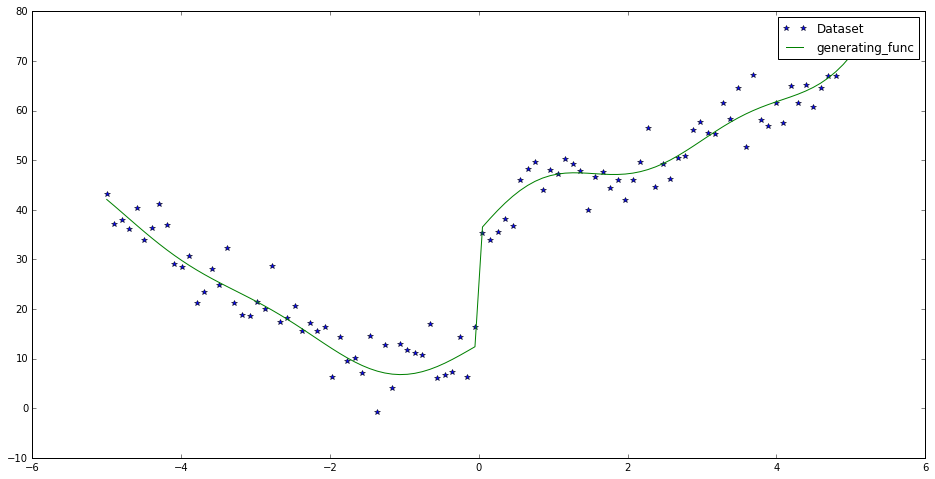

In [41]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid_and_spline)

# initialise Networks

In [7]:
from estimators import GaussianLossEstimator,GaussianLearningRateEstimator, EnsembleNetwork

gauss = GaussianLossEstimator(**params)
gauss_lr = GaussianLearningRateEstimator(**params)
vanilla = EnsembleNetwork(**params)

In [8]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)


lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

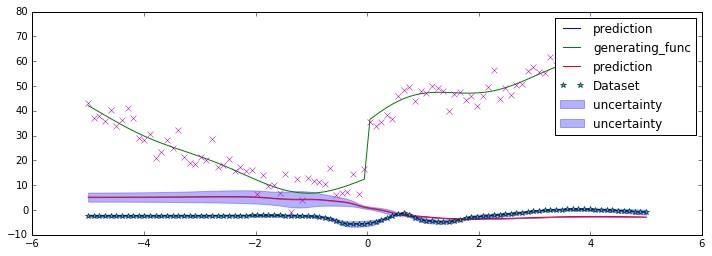

In [9]:
plot_prediction(X,
                gauss_preds,
                sorted_index,
                gauss_var,
                generating_func=generate_sinoid)
plot_prediction(X,
                lr_preds,
                sorted_index,
                lr_var)
plot_prediction(X,vanilla_preds,sorted_index)
plt.plot(X,y,'x')

In [10]:
evaluate_model(X,y,gauss_preds)

RSME is 42.90150451660156


In [11]:
evaluate_model(X,y,lr_preds)

RSME is 41.92979049682617


In [12]:
evaluate_model(X,y,vanilla_preds)

RSME is 42.90150451660156


# Training


## GaussianLossEstimator

Maye replace min_variance with 

In [13]:
num_eps

25

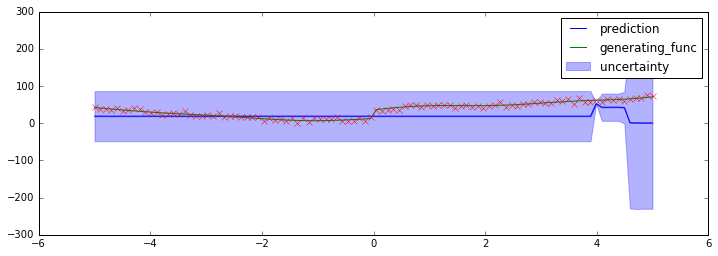

RSME is 26.388952255249023
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 73.3376235961914
COVERAGE/MEAN_VAR is 0.013499210247813552


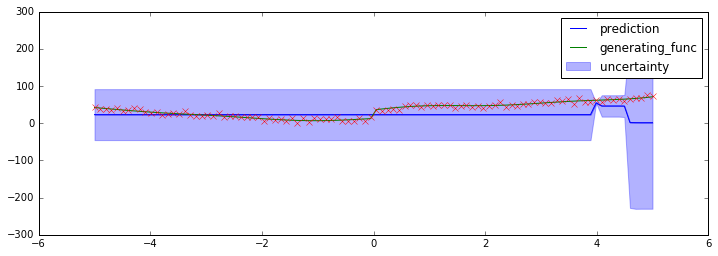

RSME is 24.455429077148438
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 73.97482299804688
COVERAGE/MEAN_VAR is 0.013382931649949855


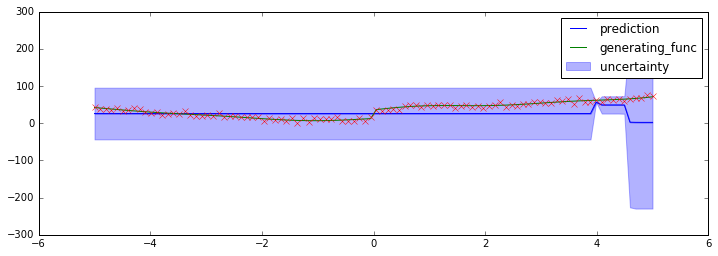

RSME is 23.36404800415039
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 74.5881118774414
COVERAGE/MEAN_VAR is 0.01327289262431937


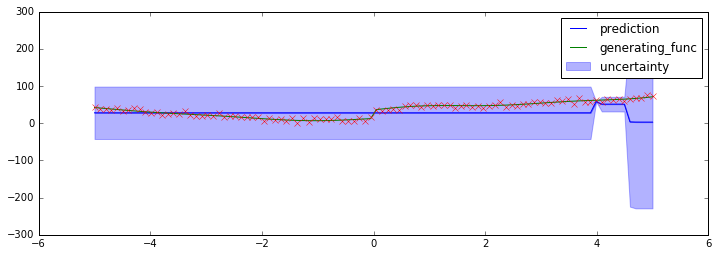

RSME is 22.726606369018555
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 75.20489501953125
COVERAGE/MEAN_VAR is 0.013164036725839321


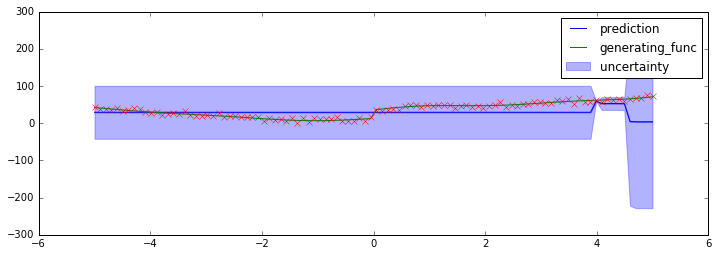

RSME is 22.332273483276367
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 75.82211303710938
COVERAGE/MEAN_VAR is 0.013056876949808395


In [14]:
errors = train_and_plot(gauss,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

In [15]:
#plot_error(errors)

gauss_error_list = []
#for i in tqdm(range(num_eps)):
for i in range(num_eps):
    #gauss.train(X,y)
    errors = gauss.train_and_evaluate(X,y)
    gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        gauss_preds = gauss.predict(X)
        gauss_var = gauss.predict_var(X)

        #lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)
#plt.show()

## GaussianLearningRateEstimator

gauss_lr_error_list = []
for i in range(num_eps):
    errors = gauss_lr.train_and_evaluate(X,y)
    gauss_lr_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        gauss_preds = gauss_lr.predict(X)
        gauss_var = gauss_lr.predict_var(X)

        #3lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)

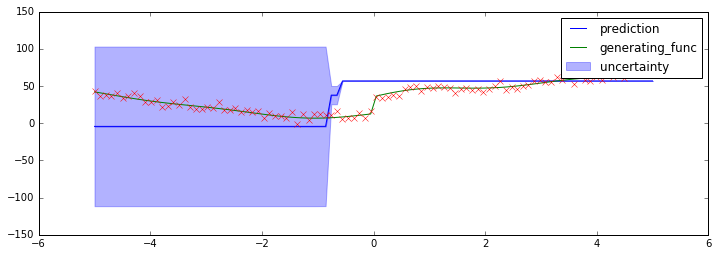

RSME is 23.358245849609375
COVERAGE PROBABILITY is 0.42
MEAN VARIANCE is 45.29296875
COVERAGE/MEAN_VAR is 0.009272962483829236


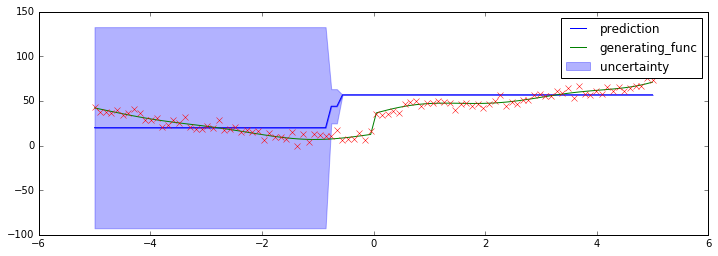

RSME is 16.23760986328125
COVERAGE PROBABILITY is 0.42
MEAN VARIANCE is 47.691375732421875
COVERAGE/MEAN_VAR is 0.008806623703968194


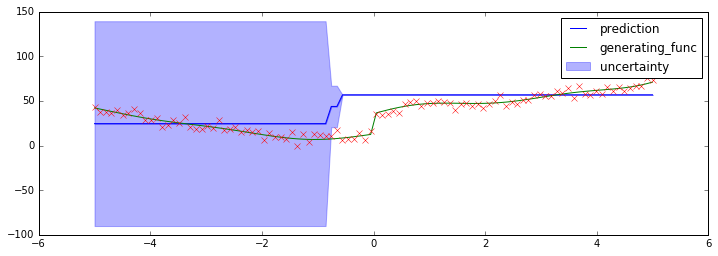

RSME is 16.257537841796875
COVERAGE PROBABILITY is 0.42
MEAN VARIANCE is 48.64348220825195
COVERAGE/MEAN_VAR is 0.008634250282533238


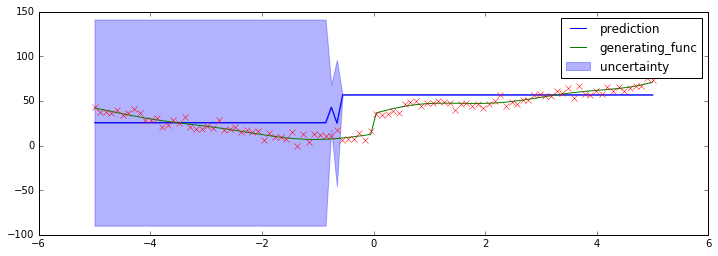

RSME is 16.133132934570312
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 49.448753356933594
COVERAGE/MEAN_VAR is 0.008695871398337413


RSME is 16.141498565673828
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 49.640899658203125
COVERAGE/MEAN_VAR is 0.008662212066274322


In [16]:
errors = train_and_plot(gauss_lr,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

In [17]:
#plot_error(errors)

## Vanilla Neural Network for comparisson

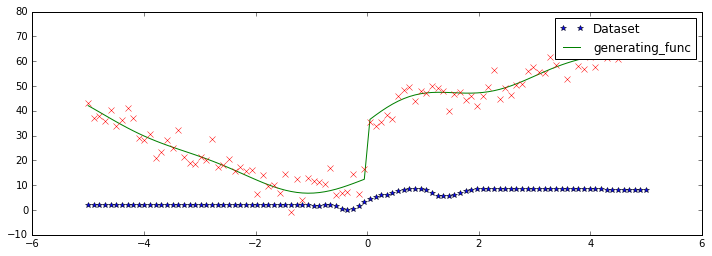

RSME is 35.77388000488281


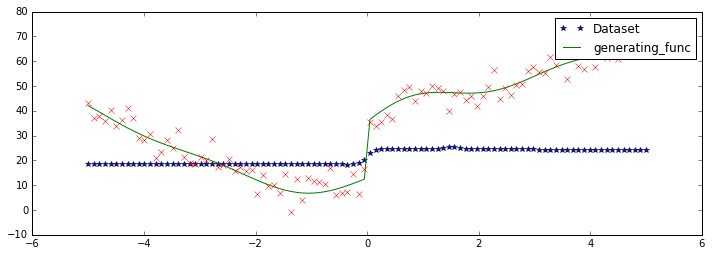

RSME is 22.57742691040039


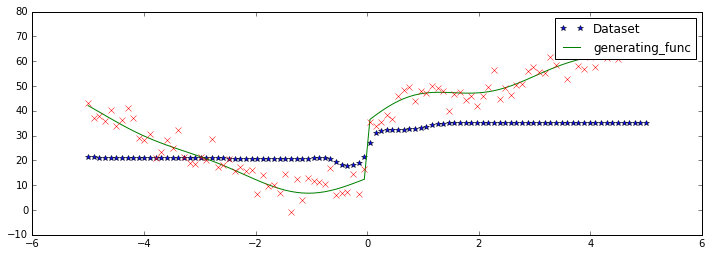

RSME is 16.357290267944336


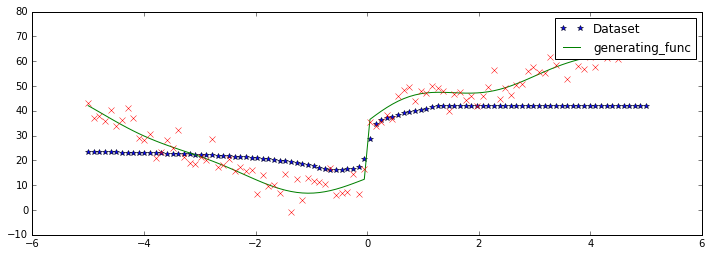

RSME is 12.232804298400879


RSME is 9.528573036193848


In [18]:
vanilla_errors = []
for i in range(num_eps):

    vanilla.train(X,y)
    if i%(num_eps/5) ==0:


        vanilla_preds = vanilla.predict(X)
        plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds)

# loop over experiment forever

In [19]:

def plot_error_tmp(error_list, variance_list=False):
    if len(variance_list) > 0:
        diff = error_list - variance_list
        sum_ = error_list + variance_list
        X = np.linspace(0, len(error_list), len(error_list))
        plt.plot()
        plt.xlim = 50
        plt.fill_between(X, error_list, diff, alpha=.3,
                         color='b')
        plt.fill_between(X, error_list, sum_, alpha=.3,
                         color='b')
        #plt.plot(X,error_list)
        plt.xlim = 50
        plt.show()

        
    else:
        plt.plot(np.squeeze(error_list))
        
        
def plottt(error_list):
    plt.plot(np.squeeze(error_list))

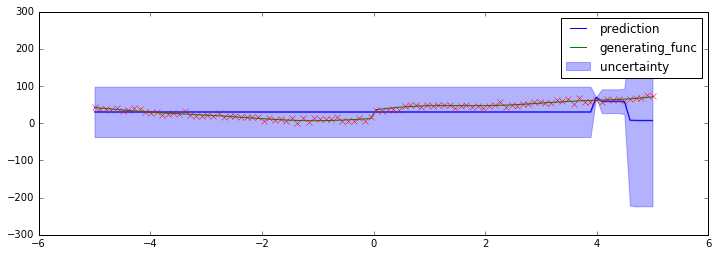

RSME is 21.58622169494629
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 73.4151840209961
COVERAGE/MEAN_VAR is 0.013484948831795733


RSME is 23.536792755126953
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 74.46508026123047
COVERAGE/MEAN_VAR is 0.013294822170700512


RSME is 21.739229202270508
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 75.15350341796875
COVERAGE/MEAN_VAR is 0.013173038580704368


RSME is 22.11310386657715
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 76.30746459960938
COVERAGE/MEAN_VAR is 0.012973829037494555


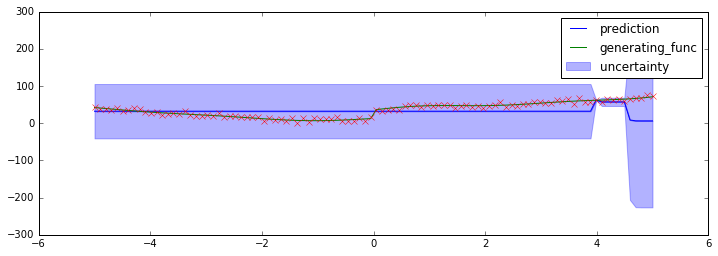

RSME is 21.623355865478516
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 77.03616333007812
COVERAGE/MEAN_VAR is 0.012851107287860776


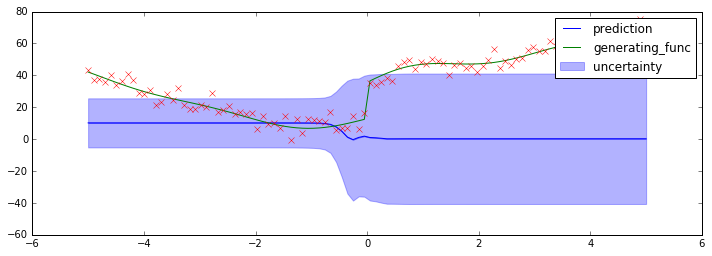

RSME is 39.20695495605469
COVERAGE PROBABILITY is 0.41
MEAN VARIANCE is 29.22988510131836
COVERAGE/MEAN_VAR is 0.01402674004974134


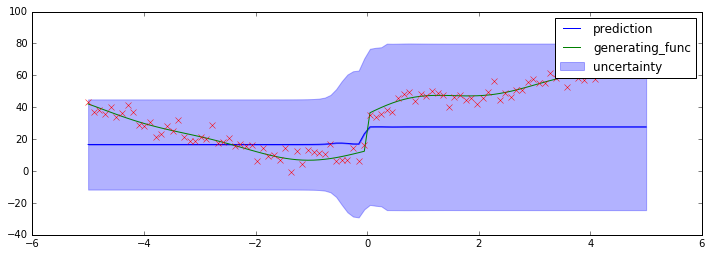

RSME is 20.71111297607422
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 41.068885803222656
COVERAGE/MEAN_VAR is 0.02434933357557829


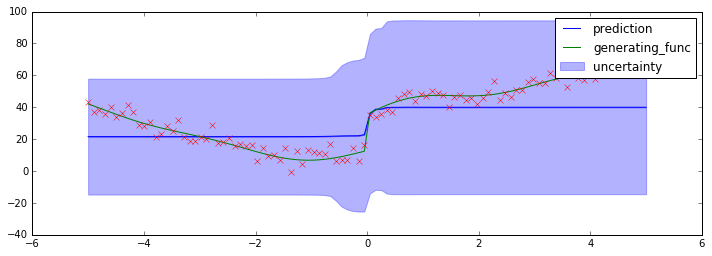

RSME is 13.85426139831543
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 45.89470291137695
COVERAGE/MEAN_VAR is 0.021789006934656668


RSME is 11.519743919372559
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 46.56809997558594
COVERAGE/MEAN_VAR is 0.021473927442267685


RSME is 10.661436080932617
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 46.84845733642578
COVERAGE/MEAN_VAR is 0.021345420038462536


RSME is 23.190753936767578
COVERAGE PROBABILITY is 0.78
MEAN VARIANCE is 27.862703323364258
COVERAGE/MEAN_VAR is 0.027994412133941483


RSME is 10.584869384765625
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 26.778188705444336
COVERAGE/MEAN_VAR is 0.03697038701496344


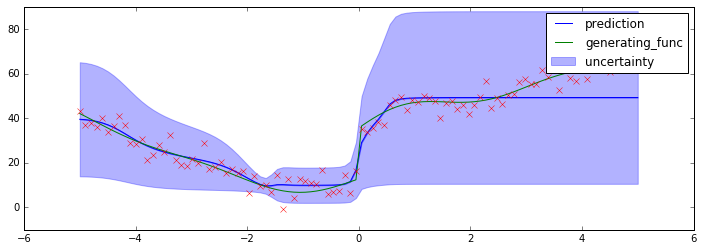

RSME is 7.349813938140869
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 25.29279327392578
COVERAGE/MEAN_VAR is 0.03874621475716078


RSME is 6.446500778198242
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 24.402528762817383
COVERAGE/MEAN_VAR is 0.0401597723549555


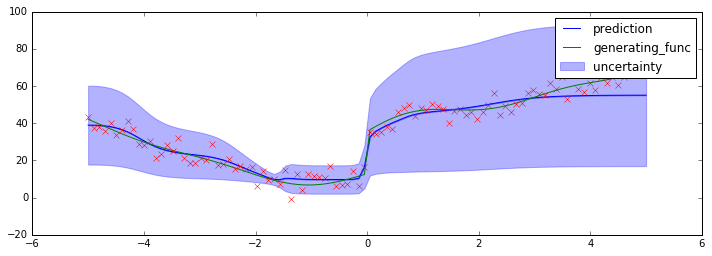

RSME is 5.4529314041137695
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 22.911821365356445
COVERAGE/MEAN_VAR is 0.042772679848220085


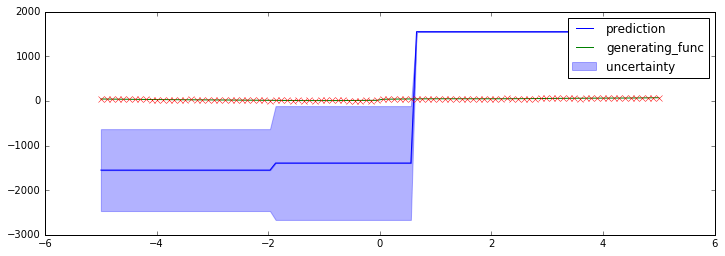

RSME is 1500.29833984375
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 603.134765625
COVERAGE/MEAN_VAR is 0.0


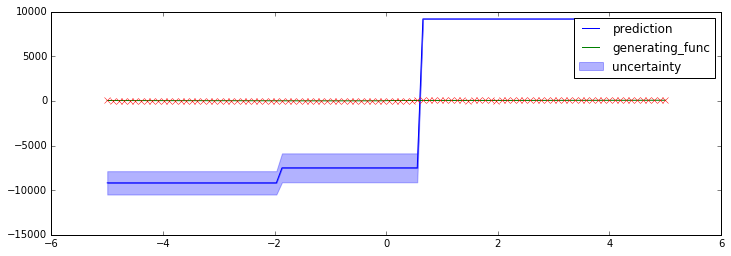

RSME is 8777.533203125
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 810.4742431640625
COVERAGE/MEAN_VAR is 0.0


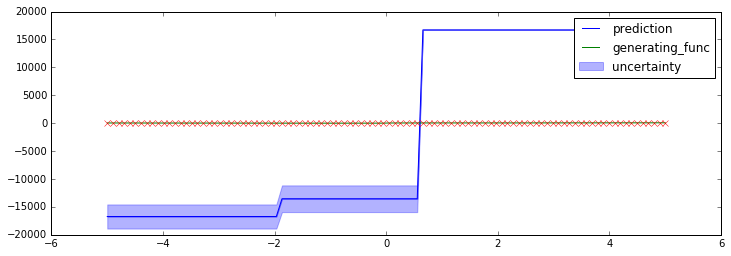

RSME is 15972.4111328125
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 1268.89990234375
COVERAGE/MEAN_VAR is 0.0


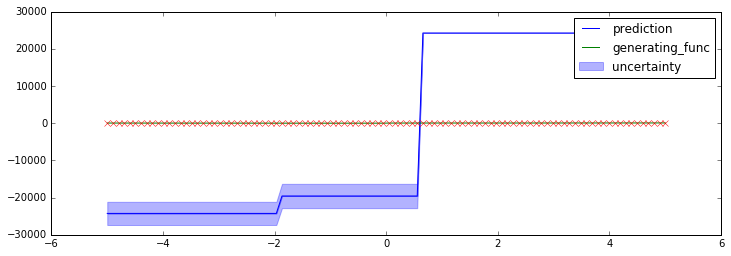

RSME is 23155.51953125
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 1782.4981689453125
COVERAGE/MEAN_VAR is 0.0


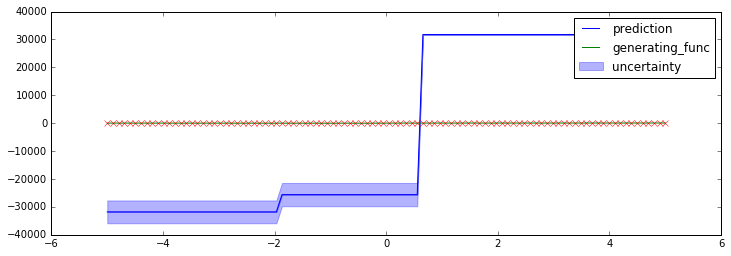

RSME is 30336.98828125
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 2310.0478515625
COVERAGE/MEAN_VAR is 0.0


RSME is 22.043859481811523
COVERAGE PROBABILITY is 0.81
MEAN VARIANCE is 27.522377014160156
COVERAGE/MEAN_VAR is 0.029430597494658917


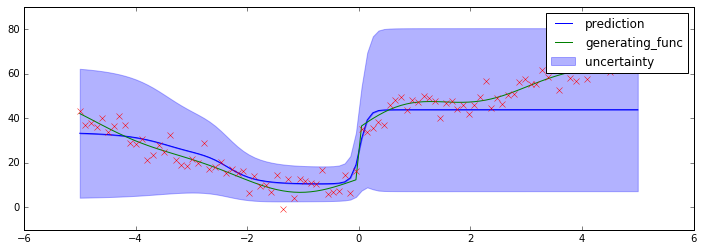

RSME is 9.928932189941406
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 26.297958374023438
COVERAGE/MEAN_VAR is 0.037645507910526656


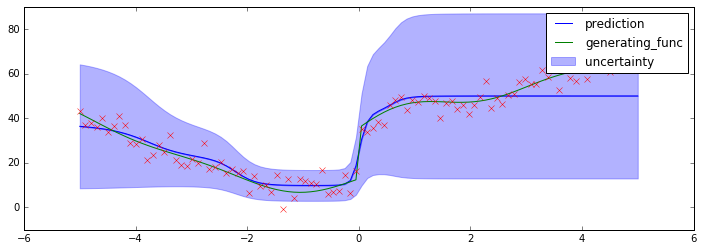

RSME is 7.262914180755615
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 24.838842391967773
COVERAGE/MEAN_VAR is 0.03945433464793457


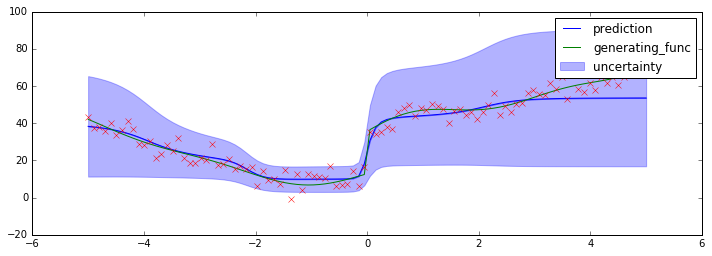

RSME is 5.9634108543396
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 22.491239547729492
COVERAGE/MEAN_VAR is 0.04357252066611561


RSME is 4.966523170471191
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 21.042543411254883
COVERAGE/MEAN_VAR is 0.047047544617181844


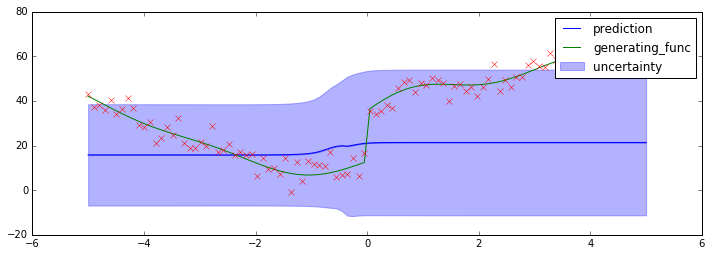

RSME is 24.795991897583008
COVERAGE PROBABILITY is 0.75
MEAN VARIANCE is 28.273027420043945
COVERAGE/MEAN_VAR is 0.02652704957475807


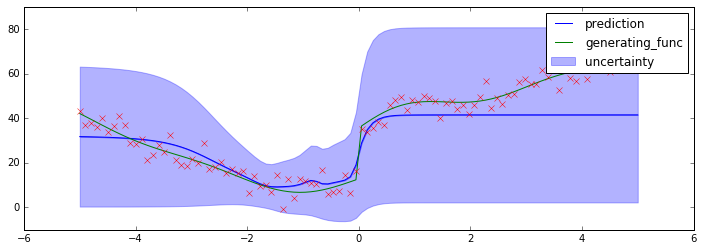

RSME is 11.123059272766113
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 30.124021530151367
COVERAGE/MEAN_VAR is 0.03319609896703507


RSME is 7.46272611618042
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 28.457048416137695
COVERAGE/MEAN_VAR is 0.03514067887071909


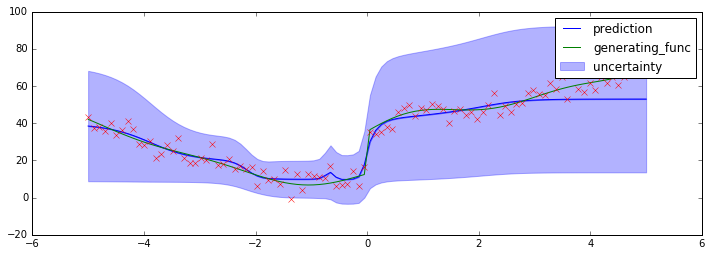

RSME is 6.074453830718994
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 26.4261417388916
COVERAGE/MEAN_VAR is 0.037462903581683575


RSME is 5.102665424346924
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 24.214162826538086
COVERAGE/MEAN_VAR is 0.04088516324483397


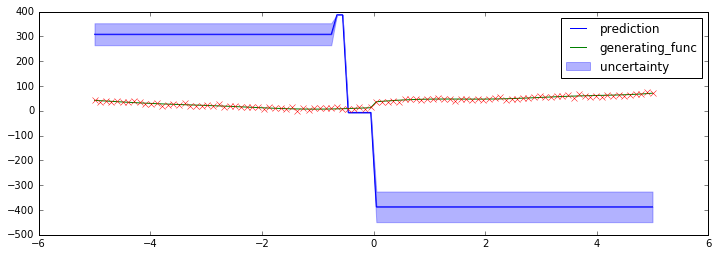

RSME is 367.6212463378906
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 49.911590576171875
COVERAGE/MEAN_VAR is 0.0


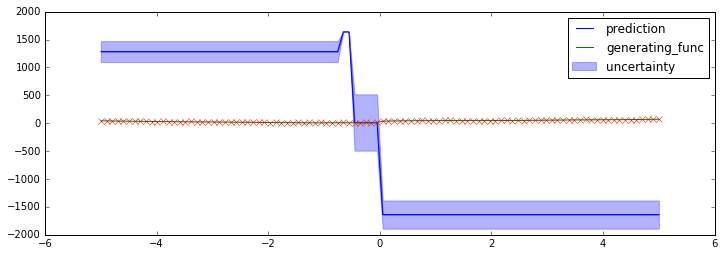

RSME is 1471.6964111328125
COVERAGE PROBABILITY is 0.05
MEAN VARIANCE is 232.48667907714844
COVERAGE/MEAN_VAR is 0.00021506608549992661


RSME is 2533.45361328125
COVERAGE PROBABILITY is 0.05
MEAN VARIANCE is 388.1289978027344
COVERAGE/MEAN_VAR is 0.00012882314973387373


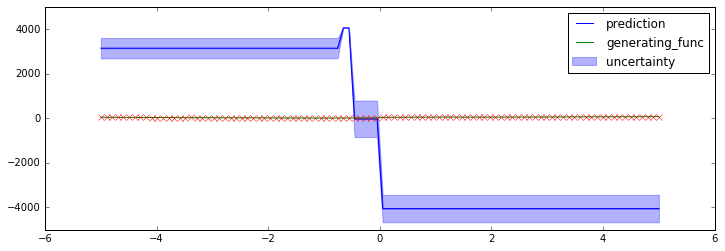

RSME is 3593.233154296875
COVERAGE PROBABILITY is 0.05
MEAN VARIANCE is 545.3847045898438
COVERAGE/MEAN_VAR is 9.167840531501975e-05


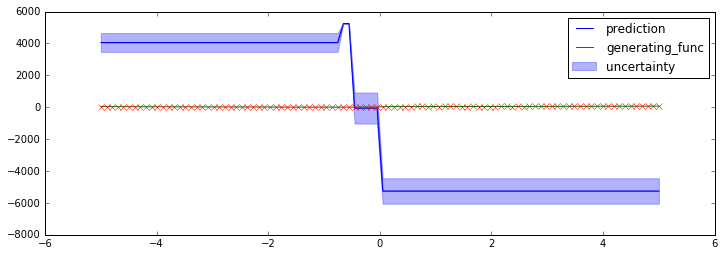

RSME is 4652.7646484375
COVERAGE PROBABILITY is 0.05
MEAN VARIANCE is 702.935302734375
COVERAGE/MEAN_VAR is 7.11303014736962e-05


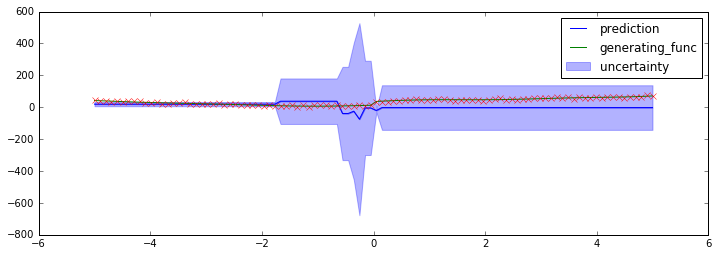

RSME is 42.66603088378906
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 110.81967163085938
COVERAGE/MEAN_VAR is 0.008031065125013115


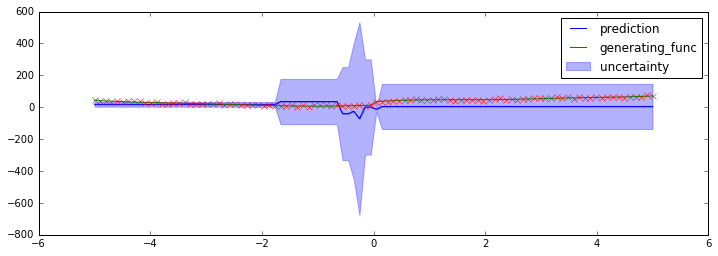

RSME is 38.0858268737793
COVERAGE PROBABILITY is 0.9
MEAN VARIANCE is 112.16287994384766
COVERAGE/MEAN_VAR is 0.00802404503567106


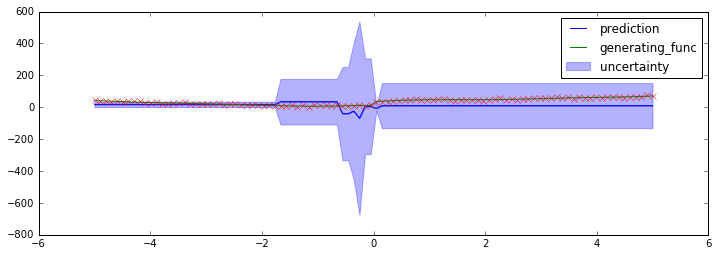

RSME is 34.691741943359375
COVERAGE PROBABILITY is 0.91
MEAN VARIANCE is 113.02958679199219
COVERAGE/MEAN_VAR is 0.00805098935444813


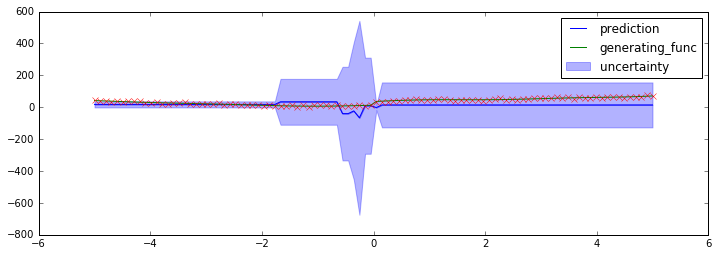

RSME is 31.838226318359375
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 113.66545104980469
COVERAGE/MEAN_VAR is 0.008181905683834421


RSME is 29.407241821289062
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 114.15057373046875
COVERAGE/MEAN_VAR is 0.008409944590088026


RSME is 24.11201286315918
COVERAGE PROBABILITY is 0.78
MEAN VARIANCE is 30.397550582885742
COVERAGE/MEAN_VAR is 0.025659962235218756


RSME is 13.842823028564453
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 33.514984130859375
COVERAGE/MEAN_VAR is 0.029837400372785393


RSME is 8.057785987854004
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 30.2867488861084
COVERAGE/MEAN_VAR is 0.03301773999449209


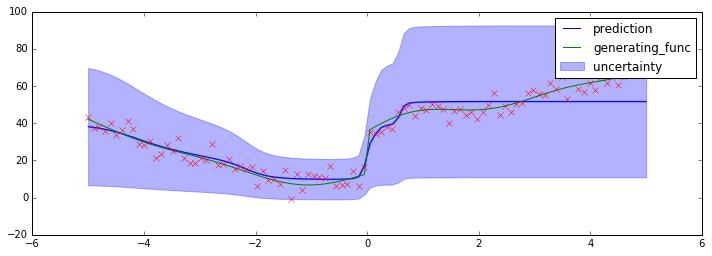

RSME is 6.704973220825195
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 28.915990829467773
COVERAGE/MEAN_VAR is 0.03458294083358602


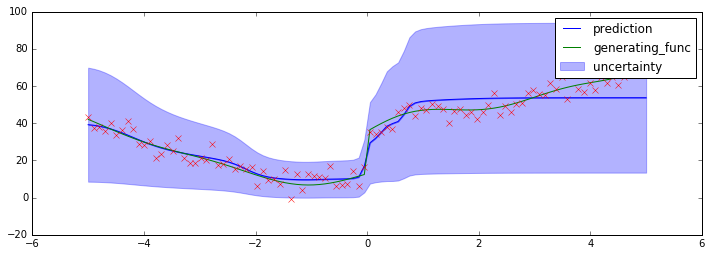

RSME is 6.252498149871826
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 27.586416244506836
COVERAGE/MEAN_VAR is 0.03588722765673248


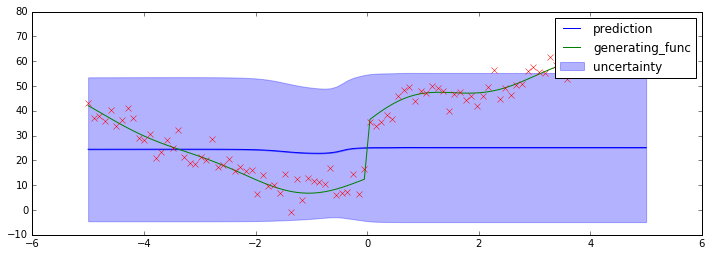

RSME is 22.202146530151367
COVERAGE PROBABILITY is 0.78
MEAN VARIANCE is 29.228593826293945
COVERAGE/MEAN_VAR is 0.02668619655928554


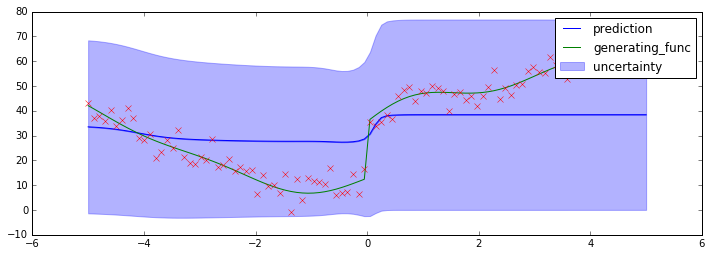

RSME is 15.295989036560059
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 34.8208122253418
COVERAGE/MEAN_VAR is 0.028718457040247405


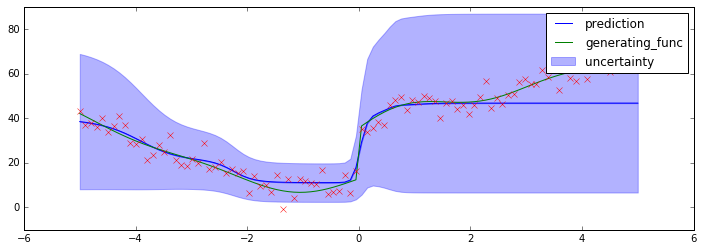

RSME is 8.382052421569824
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 27.0036678314209
COVERAGE/MEAN_VAR is 0.03666168633758918


RSME is 6.5757951736450195
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 25.164934158325195
COVERAGE/MEAN_VAR is 0.03934045659612755


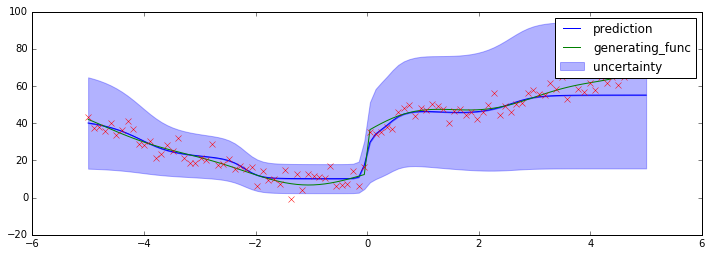

RSME is 5.31884241104126
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 23.379785537719727
COVERAGE/MEAN_VAR is 0.04234427208080184


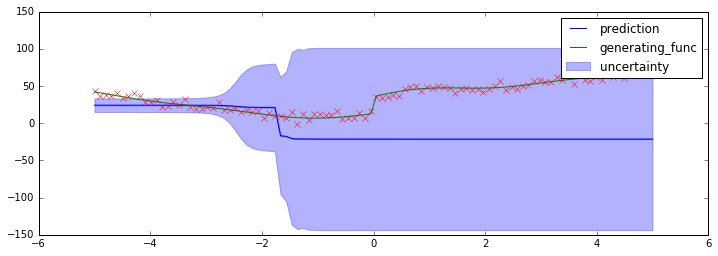

RSME is 54.518463134765625
COVERAGE PROBABILITY is 0.91
MEAN VARIANCE is 87.9112777709961
COVERAGE/MEAN_VAR is 0.010351345391321674


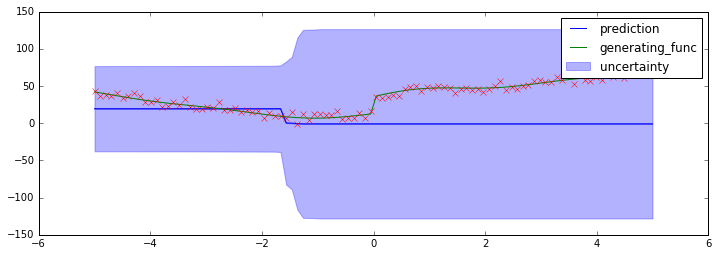

RSME is 39.30873489379883
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 102.54156494140625
COVERAGE/MEAN_VAR is 0.009752142953654107


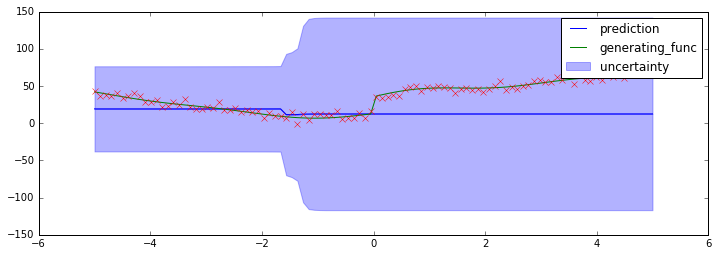

RSME is 30.048519134521484
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 103.4324722290039
COVERAGE/MEAN_VAR is 0.009668143654015707


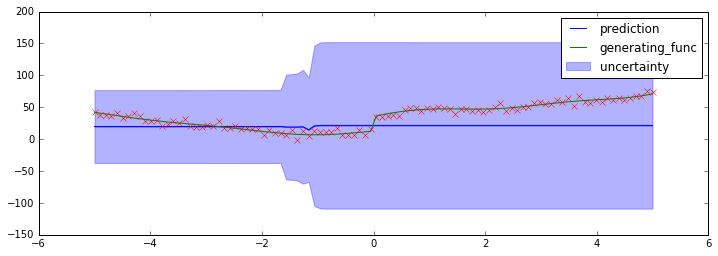

RSME is 24.42032241821289
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 103.23734283447266
COVERAGE/MEAN_VAR is 0.009686417458490451


RSME is 21.03920555114746
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 102.97533416748047
COVERAGE/MEAN_VAR is 0.009711063412269063


RSME is 56.09319305419922
COVERAGE PROBABILITY is 0.6
MEAN VARIANCE is 97.234619140625
COVERAGE/MEAN_VAR is 0.00617064174573722


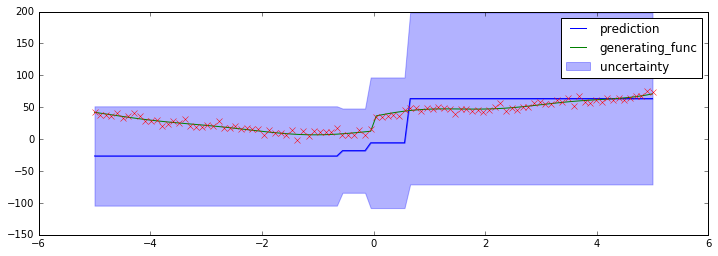

RSME is 35.88348388671875
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 103.9644546508789
COVERAGE/MEAN_VAR is 0.009618672106327893


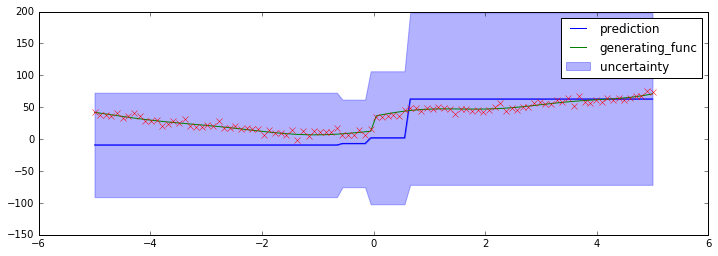

RSME is 24.89573860168457
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 106.03124237060547
COVERAGE/MEAN_VAR is 0.009431182523588209


RSME is 18.557876586914062
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 106.76492309570312
COVERAGE/MEAN_VAR is 0.009366372128640124


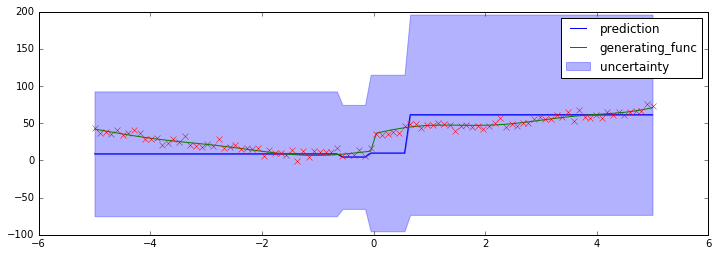

RSME is 14.992236137390137
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 106.99421691894531
COVERAGE/MEAN_VAR is 0.00934629953652132


RSME is 37.473960876464844
COVERAGE PROBABILITY is 0.31
MEAN VARIANCE is 26.884626388549805
COVERAGE/MEAN_VAR is 0.011530753506473475


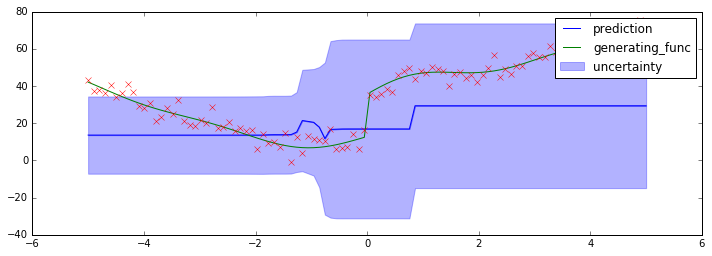

RSME is 21.064512252807617
COVERAGE PROBABILITY is 0.91
MEAN VARIANCE is 35.273380279541016
COVERAGE/MEAN_VAR is 0.025798491462634528


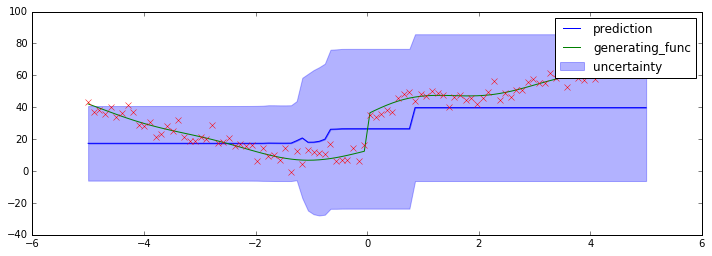

RSME is 15.143155097961426
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 37.96791458129883
COVERAGE/MEAN_VAR is 0.025811267508558423


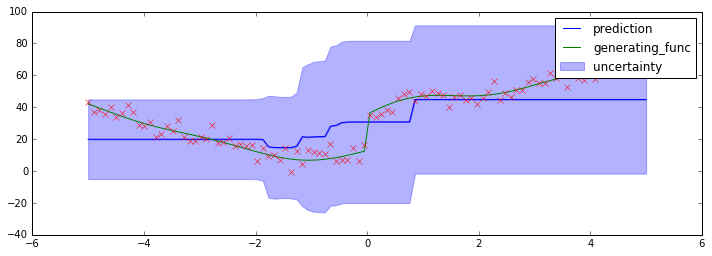

RSME is 12.787484169006348
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 39.39352798461914
COVERAGE/MEAN_VAR is 0.025384880490786233


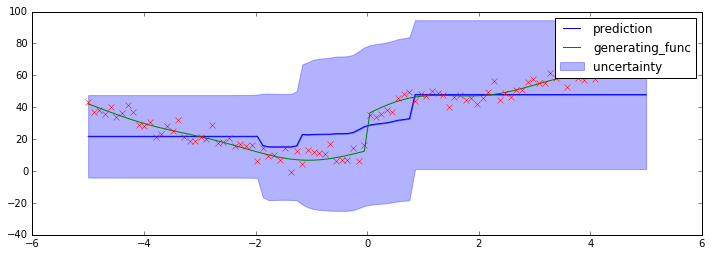

RSME is 11.077310562133789
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 39.735931396484375
COVERAGE/MEAN_VAR is 0.025166139684056198


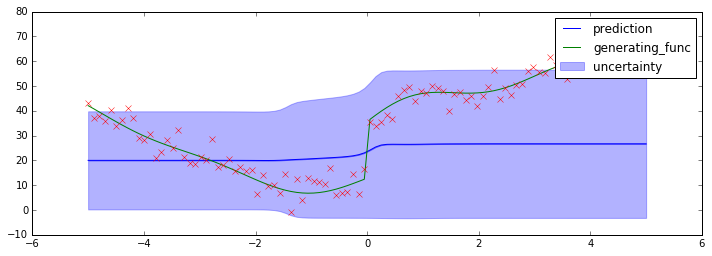

RSME is 21.27047348022461
COVERAGE PROBABILITY is 0.79
MEAN VARIANCE is 25.41726303100586
COVERAGE/MEAN_VAR is 0.031081237938022657


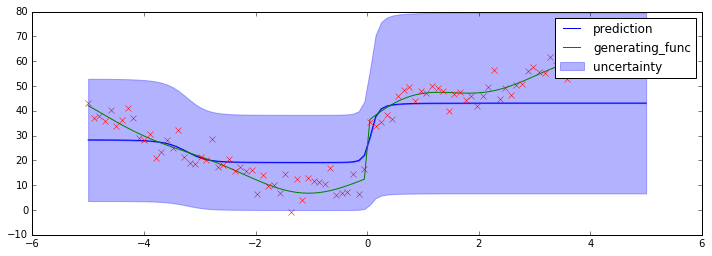

RSME is 11.282041549682617
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 28.649789810180664
COVERAGE/MEAN_VAR is 0.03455522733532254


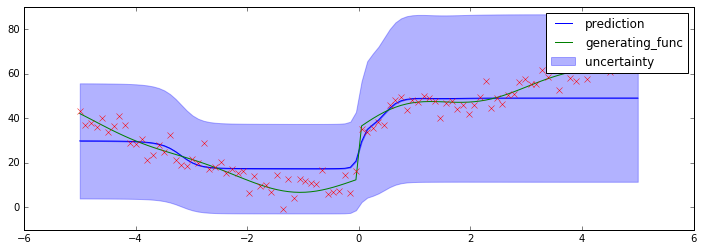

RSME is 8.540045738220215
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 29.479097366333008
COVERAGE/MEAN_VAR is 0.03392234122955417


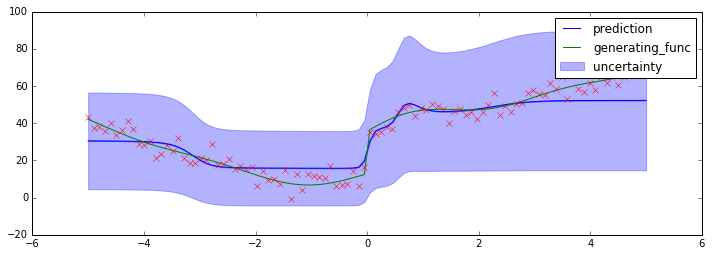

RSME is 7.207211017608643
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 28.73566436767578
COVERAGE/MEAN_VAR is 0.03479996102421357


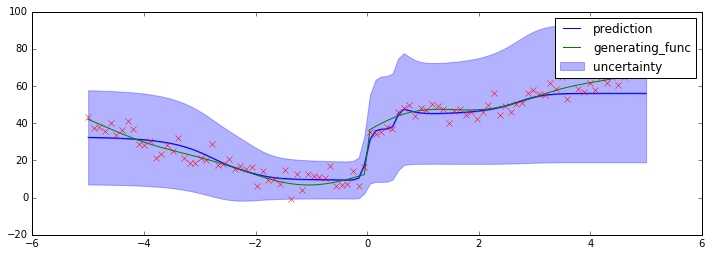

RSME is 5.4570465087890625
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 25.09588050842285
COVERAGE/MEAN_VAR is 0.03944870552231588


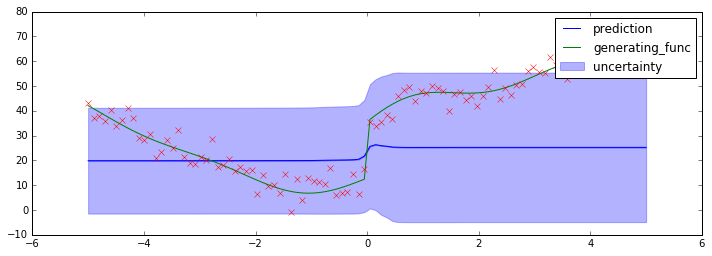

RSME is 22.055192947387695
COVERAGE PROBABILITY is 0.78
MEAN VARIANCE is 25.649457931518555
COVERAGE/MEAN_VAR is 0.030409999387999574


RSME is 13.634366035461426
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 31.778427124023438
COVERAGE/MEAN_VAR is 0.0314678884545558


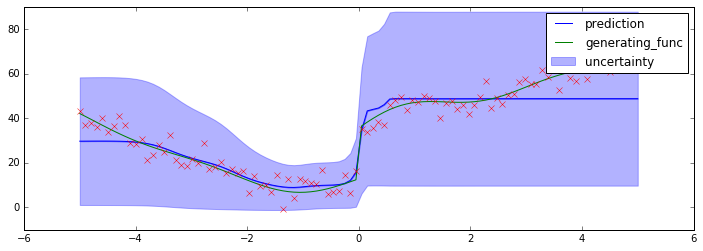

RSME is 8.055272102355957
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 28.8182373046875
COVERAGE/MEAN_VAR is 0.0347002486455805


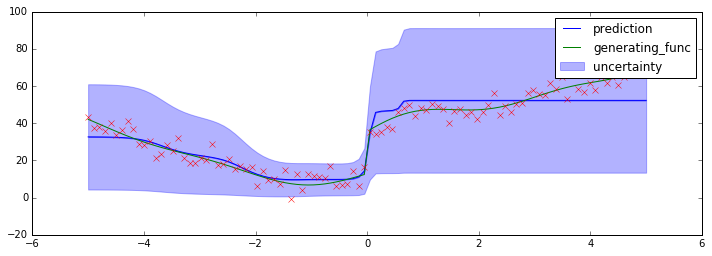

RSME is 7.069561958312988
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 27.81829071044922
COVERAGE/MEAN_VAR is 0.03558809598708134


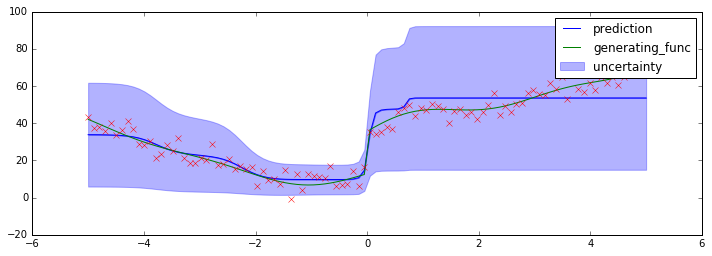

RSME is 6.8513288497924805
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 27.161548614501953
COVERAGE/MEAN_VAR is 0.036448584506386515


RSME is 19.520811080932617
COVERAGE PROBABILITY is 0.83
MEAN VARIANCE is 26.828718185424805
COVERAGE/MEAN_VAR is 0.030936997968502005


RSME is 8.6674222946167
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 25.655128479003906
COVERAGE/MEAN_VAR is 0.03897856137490785


RSME is 6.739255905151367
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 24.06374740600586
COVERAGE/MEAN_VAR is 0.04155628727013727


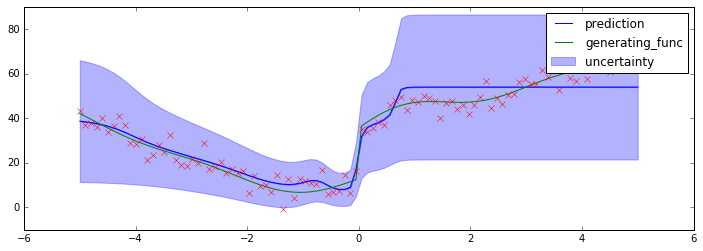

RSME is 6.3933024406433105
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 23.132240295410156
COVERAGE/MEAN_VAR is 0.04279741120432825


RSME is 6.30993127822876
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 22.45989227294922
COVERAGE/MEAN_VAR is 0.0440785729498961


RSME is 1187.2686767578125
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 75.00271606445312
COVERAGE/MEAN_VAR is 0.0


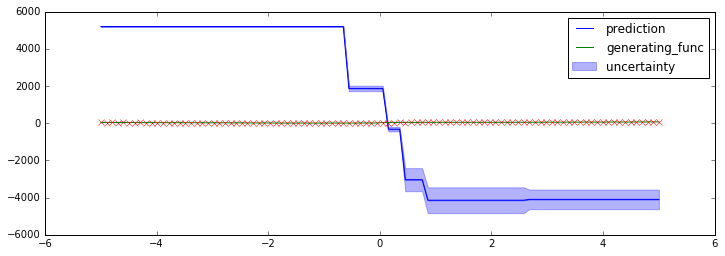

RSME is 4441.484375
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 290.43963623046875
COVERAGE/MEAN_VAR is 0.0


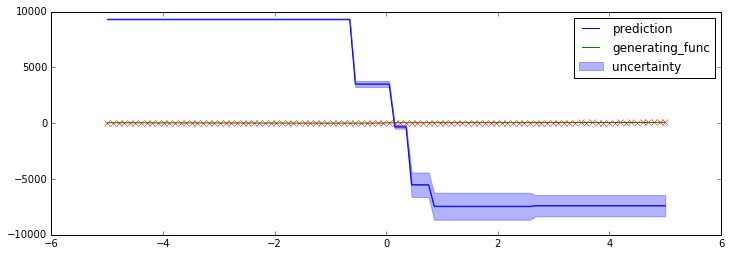

RSME is 7969.607421875
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 513.773681640625
COVERAGE/MEAN_VAR is 0.0


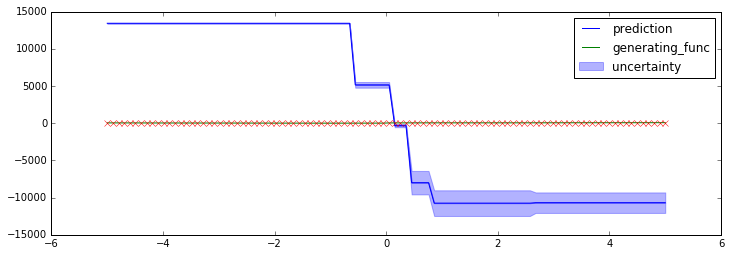

RSME is 11498.3974609375
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 738.1121826171875
COVERAGE/MEAN_VAR is 0.0


RSME is 15028.001953125
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 962.7352294921875
COVERAGE/MEAN_VAR is 0.0


RSME is 33.250919342041016
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 99.6504898071289
COVERAGE/MEAN_VAR is 0.010035073605111983


RSME is 27.448383331298828
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 100.56295776367188
COVERAGE/MEAN_VAR is 0.009944019370930313


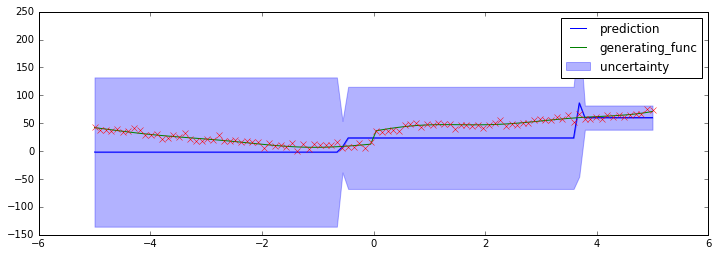

RSME is 23.3348445892334
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 100.98120880126953
COVERAGE/MEAN_VAR is 0.009902832535585849


RSME is 20.2408447265625
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 101.82691192626953
COVERAGE/MEAN_VAR is 0.009820586533391846


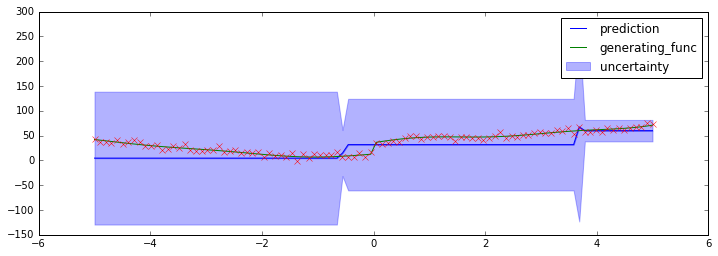

RSME is 18.026649475097656
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 101.97128295898438
COVERAGE/MEAN_VAR is 0.009806682538281167


RSME is 19.708505630493164
COVERAGE PROBABILITY is 0.74
MEAN VARIANCE is 22.753307342529297
COVERAGE/MEAN_VAR is 0.03252274444589559


RSME is 17.212594985961914
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 34.395503997802734
COVERAGE/MEAN_VAR is 0.02849209594552255


RSME is 15.210277557373047
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 39.152618408203125
COVERAGE/MEAN_VAR is 0.02554107593964861


RSME is 13.871278762817383
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 41.852542877197266
COVERAGE/MEAN_VAR is 0.02389341080025116


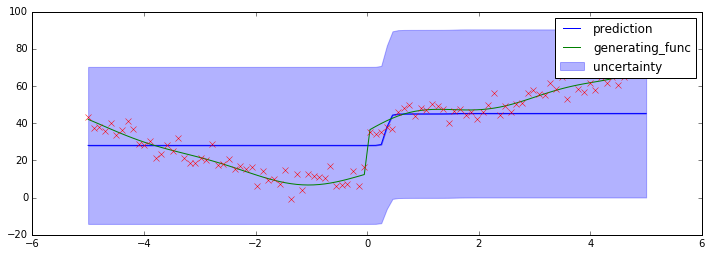

RSME is 12.90296745300293
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 43.59114074707031
COVERAGE/MEAN_VAR is 0.022940441173639355


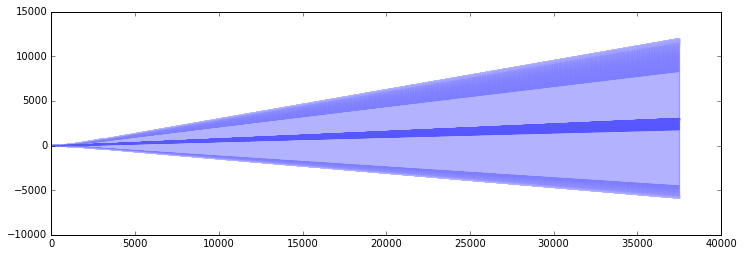

In [20]:
import numpy as np
n_samples = 20
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


bad_seeds = [2,4,10,13,15,16,9]
very_bad_seeds = [16,10]
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp = GaussianLossEstimator(**params)

    errors = train_and_plot(gauss_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

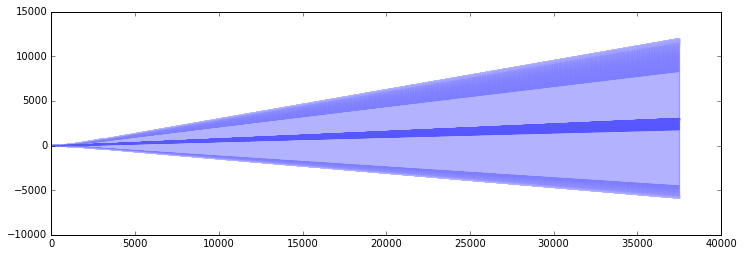

In [21]:
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

In [22]:
#for i in range(n_samples):
#    plt.plot(errors_meta[i])
#    plt.show()
#    print(i)

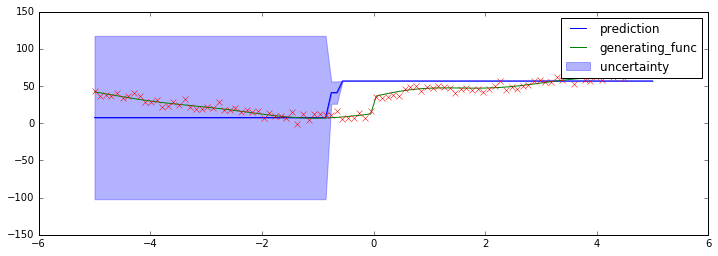

RSME is 18.59352684020996
COVERAGE PROBABILITY is 0.42
MEAN VARIANCE is 46.42860794067383
COVERAGE/MEAN_VAR is 0.009046146732132767


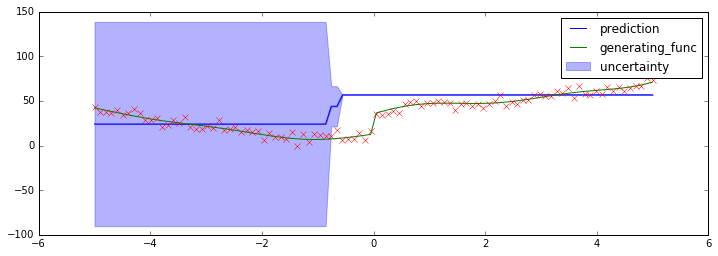

RSME is 16.238853454589844
COVERAGE PROBABILITY is 0.42
MEAN VARIANCE is 48.48971176147461
COVERAGE/MEAN_VAR is 0.008661631194386532


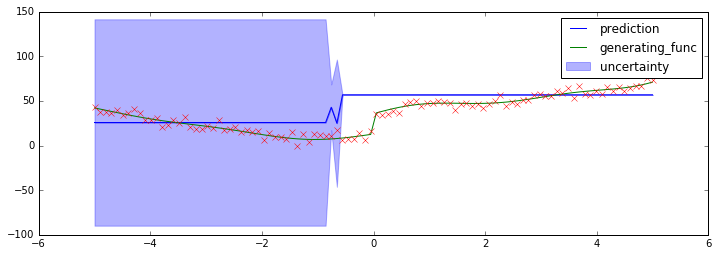

RSME is 16.13977813720703
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 49.514556884765625
COVERAGE/MEAN_VAR is 0.008684314816766544


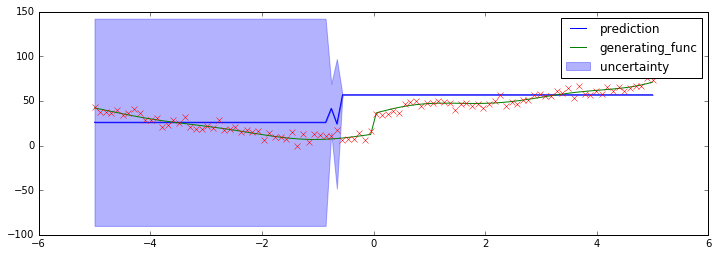

RSME is 16.13401985168457
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 49.7471809387207
COVERAGE/MEAN_VAR is 0.008643705872091128


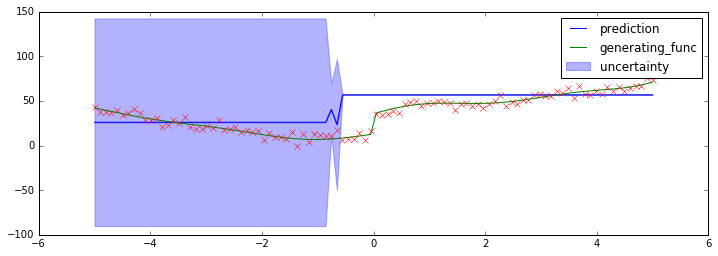

RSME is 16.11505699157715
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 49.860939025878906
COVERAGE/MEAN_VAR is 0.008623985195642237


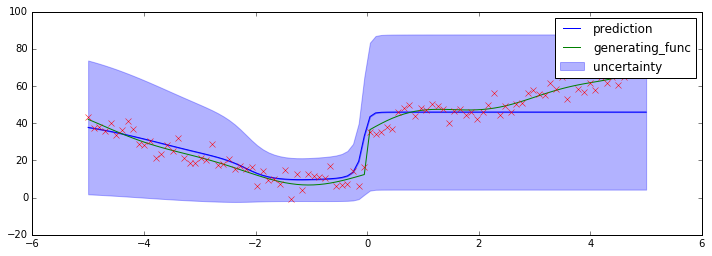

RSME is 9.156841278076172
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 32.10456466674805
COVERAGE/MEAN_VAR is 0.031148218653023477


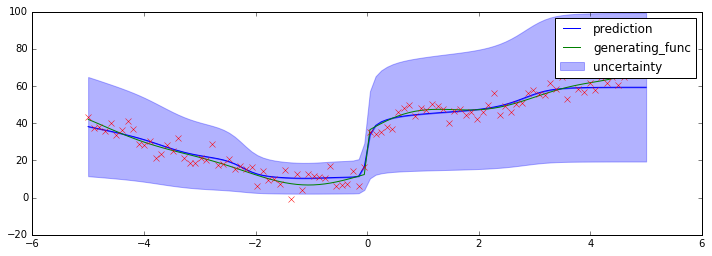

RSME is 4.564155578613281
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 25.14761734008789
COVERAGE/MEAN_VAR is 0.039367546698821365


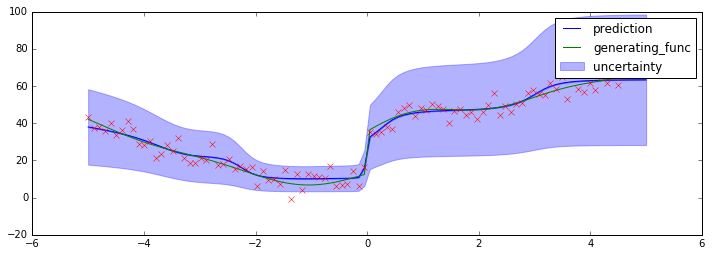

RSME is 4.026125907897949
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 20.126632690429688
COVERAGE/MEAN_VAR is 0.04918855604051193


RSME is 3.9134645462036133
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 16.458803176879883
COVERAGE/MEAN_VAR is 0.059542604007600745


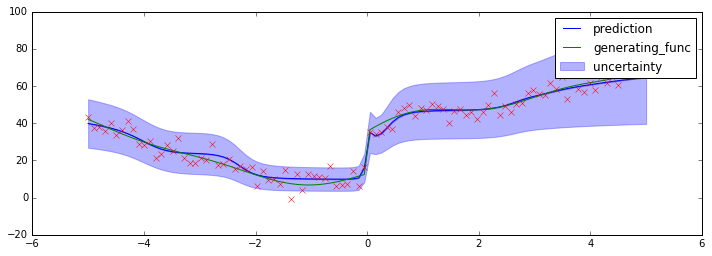

RSME is 3.887256383895874
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 13.458984375
COVERAGE/MEAN_VAR is 0.07281381512117255


RSME is 9.033639907836914
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 27.78158950805664
COVERAGE/MEAN_VAR is 0.03599506067534403


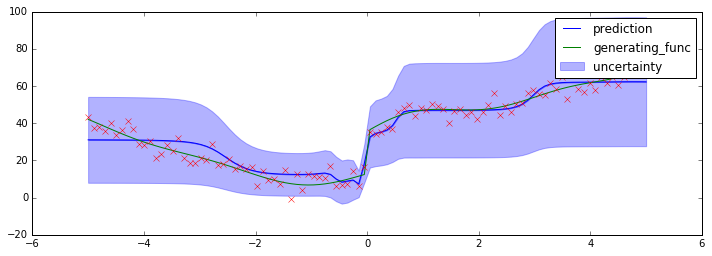

RSME is 5.023959159851074
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 22.795495986938477
COVERAGE/MEAN_VAR is 0.043429631913569994


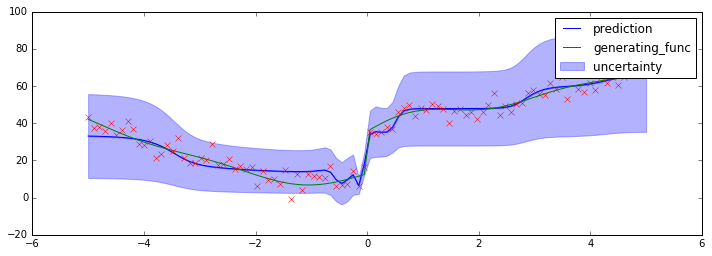

RSME is 4.403963565826416
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 18.7939510345459
COVERAGE/MEAN_VAR is 0.05267652332286288


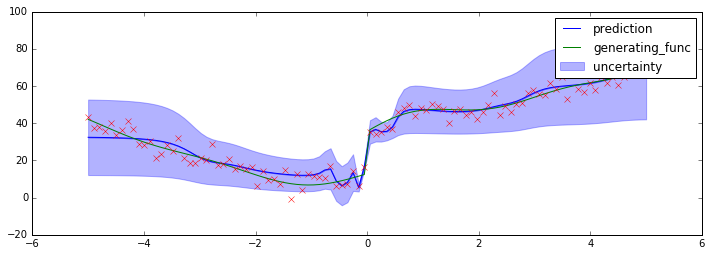

RSME is 4.160454750061035
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.771868705749512
COVERAGE/MEAN_VAR is 0.06701927966734986


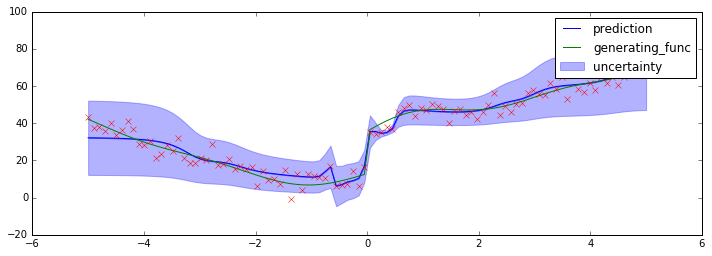

RSME is 4.110828876495361
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.630202293395996
COVERAGE/MEAN_VAR is 0.0775917896827683


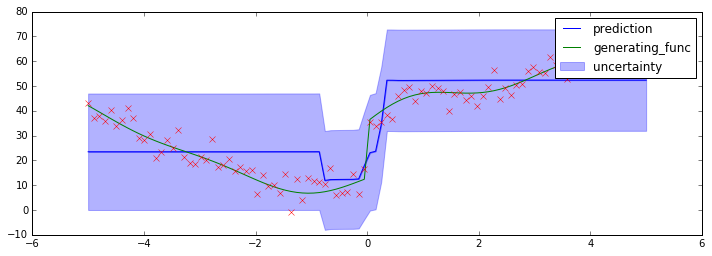

RSME is 9.790857315063477
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 21.793624877929688
COVERAGE/MEAN_VAR is 0.044508428746165805


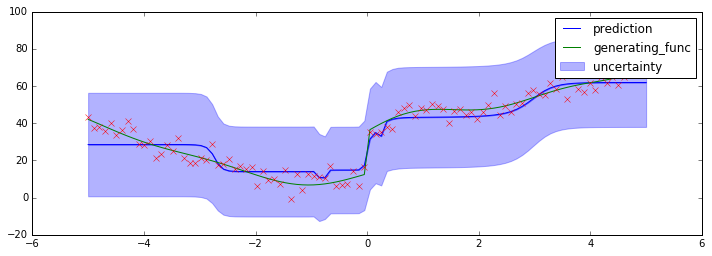

RSME is 5.7876176834106445
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 25.703020095825195
COVERAGE/MEAN_VAR is 0.03890593386581932


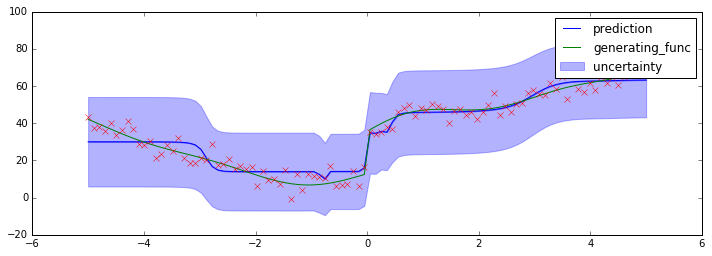

RSME is 5.329047203063965
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 21.762304306030273
COVERAGE/MEAN_VAR is 0.045951016304964676


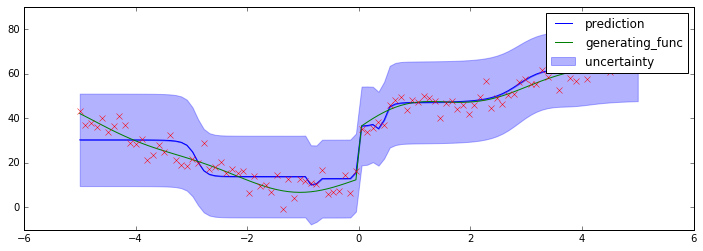

RSME is 5.194049835205078
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 18.30171012878418
COVERAGE/MEAN_VAR is 0.05463970268151286


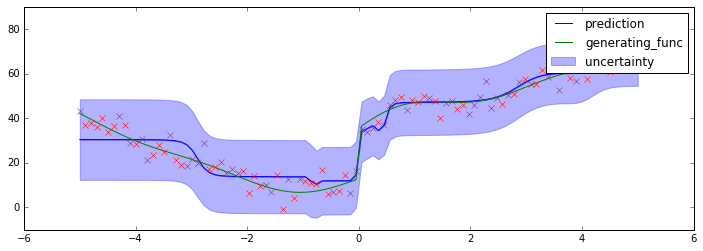

RSME is 4.9642815589904785
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 15.386667251586914
COVERAGE/MEAN_VAR is 0.06499133201810577


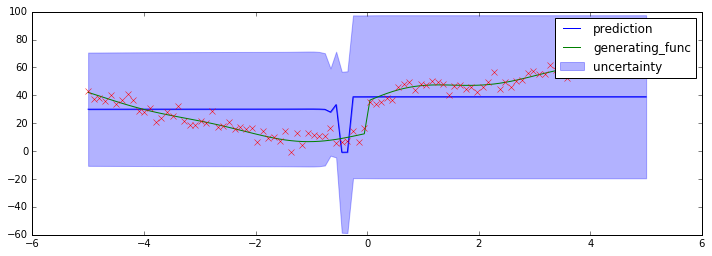

RSME is 16.03148078918457
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 50.39303207397461
COVERAGE/MEAN_VAR is 0.019844013325732154


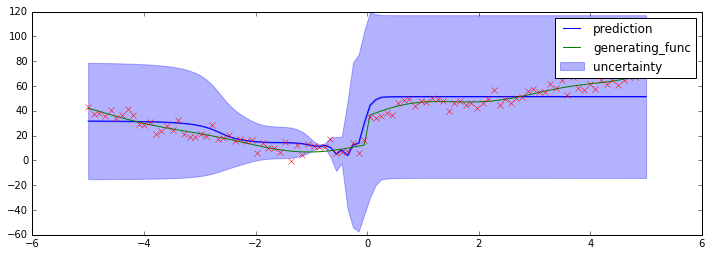

RSME is 8.125284194946289
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 49.00077819824219
COVERAGE/MEAN_VAR is 0.019999682373108837


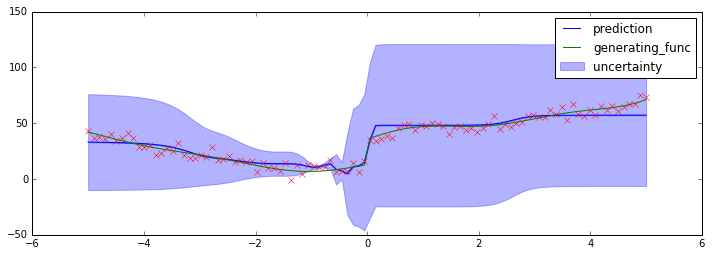

RSME is 5.755326271057129
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 47.40630340576172
COVERAGE/MEAN_VAR is 0.02067235640821747


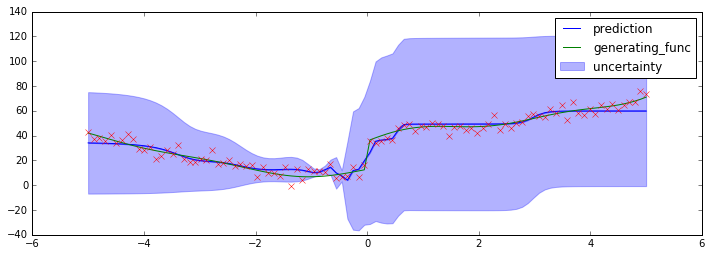

RSME is 4.728524684906006
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 44.91249465942383
COVERAGE/MEAN_VAR is 0.022042863739974234


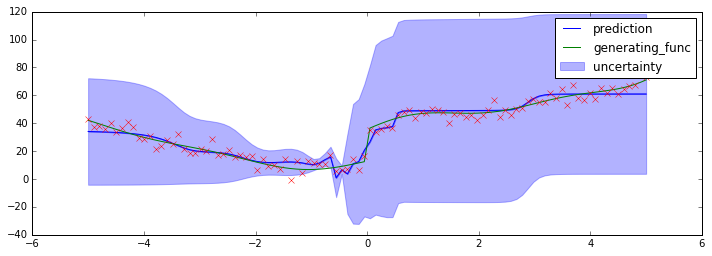

RSME is 4.568536758422852
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 42.273101806640625
COVERAGE/MEAN_VAR is 0.02341914734642165


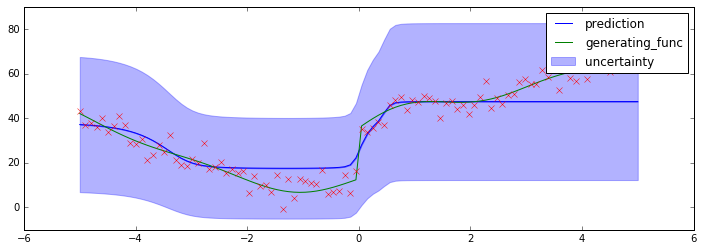

RSME is 8.855013847351074
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 29.786840438842773
COVERAGE/MEAN_VAR is 0.033571872184737506


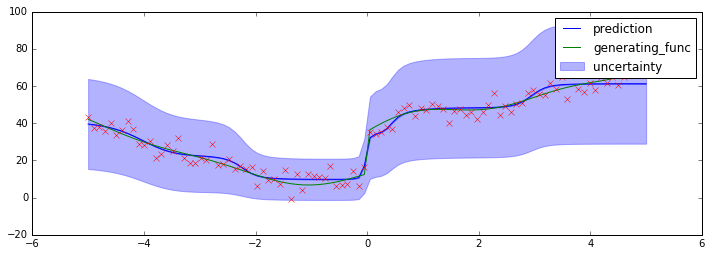

RSME is 4.114607334136963
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 22.7087345123291
COVERAGE/MEAN_VAR is 0.04403591928282383


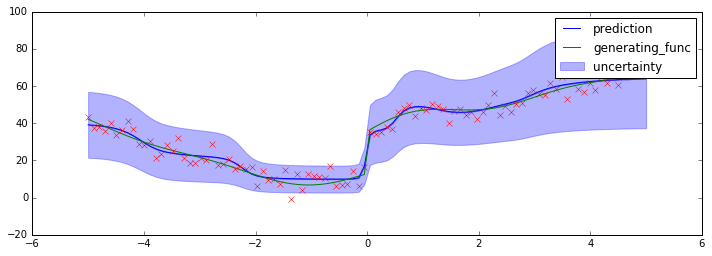

RSME is 3.815394401550293
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.66673469543457
COVERAGE/MEAN_VAR is 0.05939975754646082


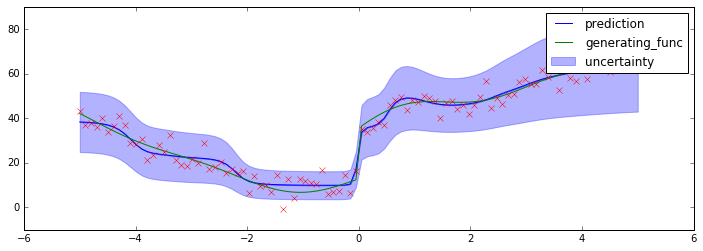

RSME is 3.7933573722839355
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.74484634399414
COVERAGE/MEAN_VAR is 0.07689382622190762


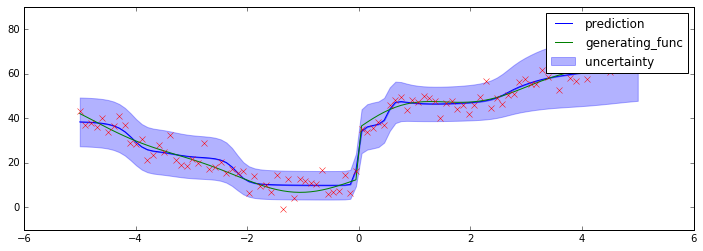

RSME is 3.7189157009124756
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.000988006591797
COVERAGE/MEAN_VAR is 0.09699041728283835


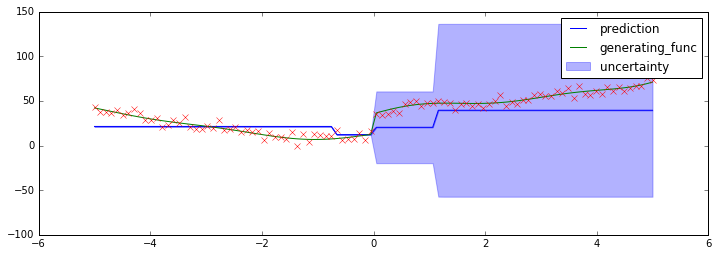

RSME is 15.51905345916748
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 42.17864227294922
COVERAGE/MEAN_VAR is 0.01185434080035974


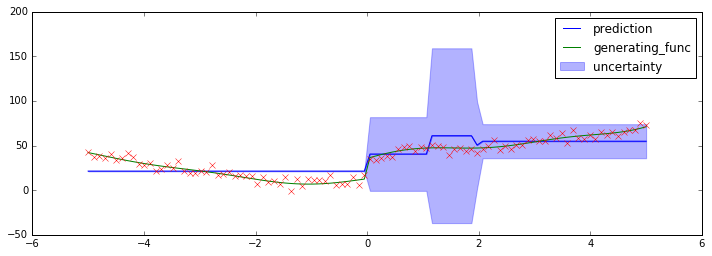

RSME is 10.2949857711792
COVERAGE PROBABILITY is 0.49
MEAN VARIANCE is 18.580842971801758
COVERAGE/MEAN_VAR is 0.026371247028115077


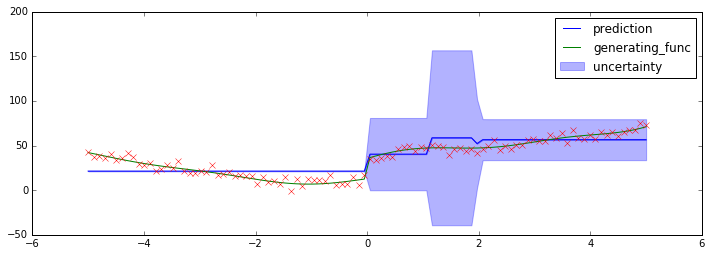

RSME is 9.92032527923584
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 19.680438995361328
COVERAGE/MEAN_VAR is 0.02540593734305672


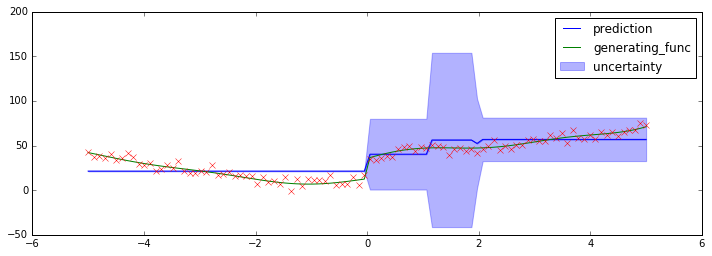

RSME is 9.686382293701172
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 19.961767196655273
COVERAGE/MEAN_VAR is 0.025047882538364555


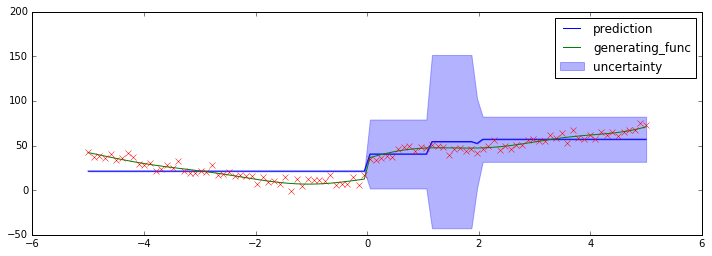

RSME is 9.53998851776123
COVERAGE PROBABILITY is 0.5
MEAN VARIANCE is 20.098909378051758
COVERAGE/MEAN_VAR is 0.02487697171001755


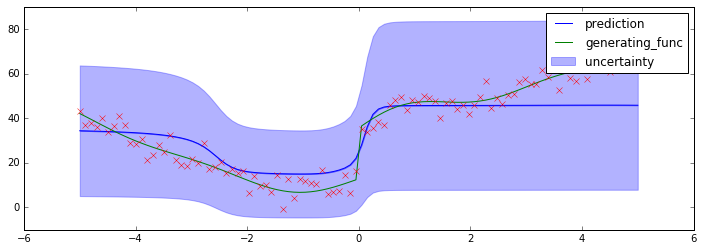

RSME is 9.658699989318848
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 30.729223251342773
COVERAGE/MEAN_VAR is 0.032542312957952915


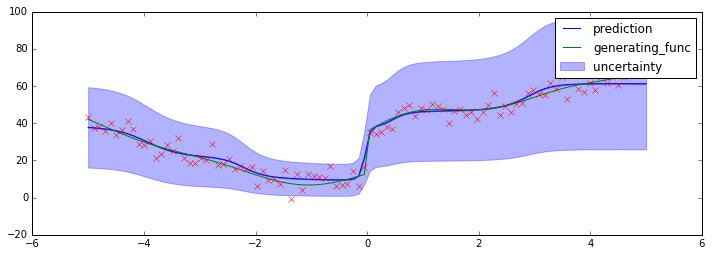

RSME is 4.213019847869873
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 22.1679744720459
COVERAGE/MEAN_VAR is 0.044659019309518


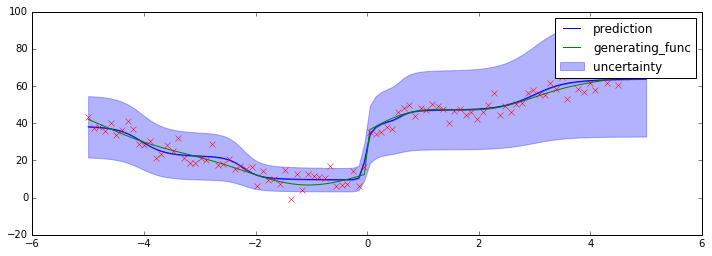

RSME is 3.9755964279174805
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 17.683124542236328
COVERAGE/MEAN_VAR is 0.05542007000285836


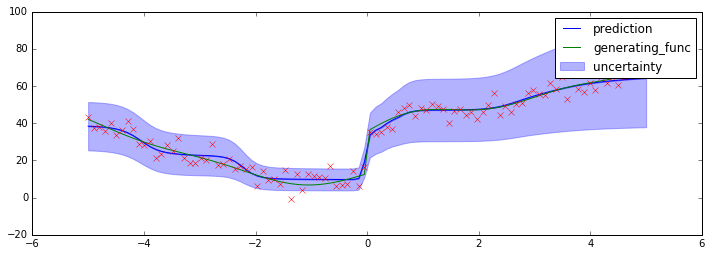

RSME is 3.8971142768859863
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 14.470721244812012
COVERAGE/MEAN_VAR is 0.06772295474569699


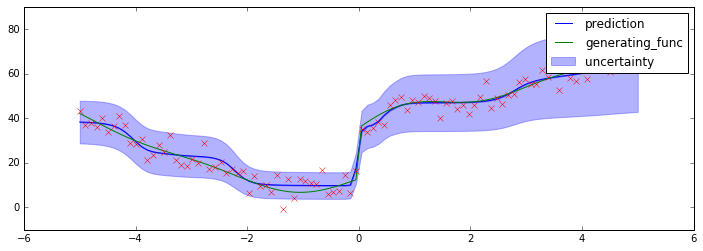

RSME is 3.820539712905884
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.681994438171387
COVERAGE/MEAN_VAR is 0.08388978484682466


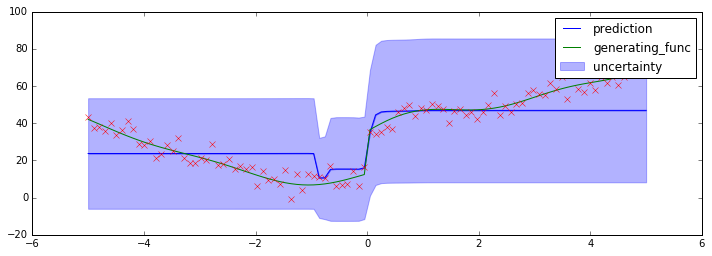

RSME is 10.826353073120117
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 33.82502746582031
COVERAGE/MEAN_VAR is 0.02956390799713275


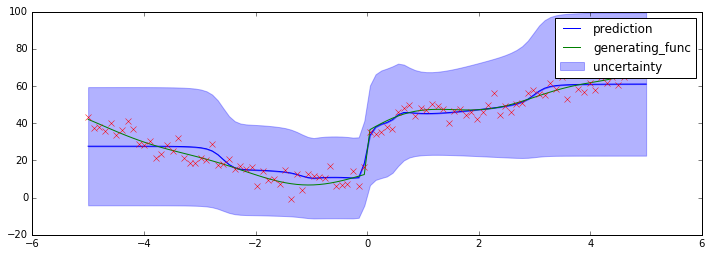

RSME is 5.484650135040283
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 29.037128448486328
COVERAGE/MEAN_VAR is 0.034438667093891956


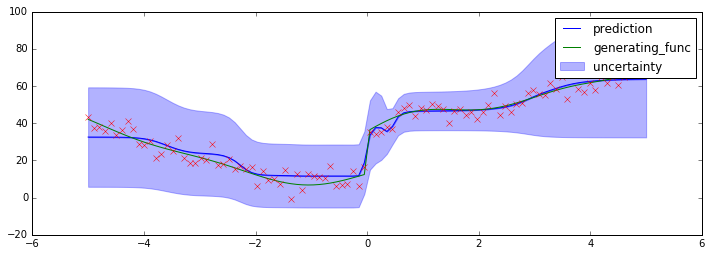

RSME is 4.422011852264404
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 20.20167350769043
COVERAGE/MEAN_VAR is 0.049500849502360146


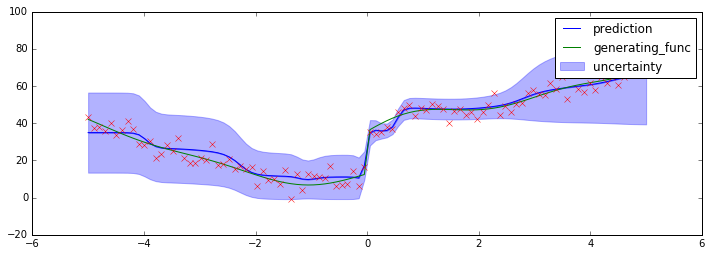

RSME is 4.00478982925415
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 14.1193208694458
COVERAGE/MEAN_VAR is 0.0687001881300877


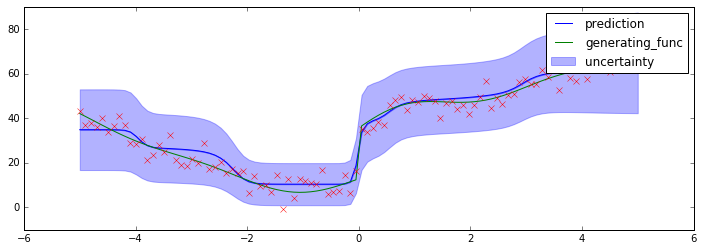

RSME is 4.241091251373291
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.30084228515625
COVERAGE/MEAN_VAR is 0.06470232040496392


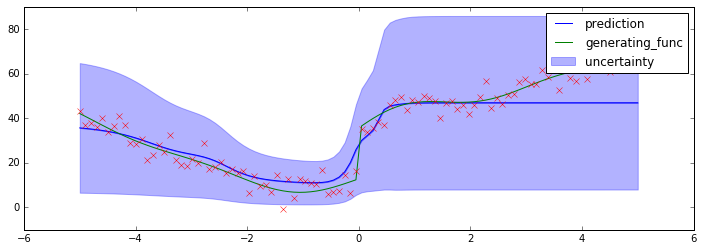

RSME is 8.552167892456055
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 27.784849166870117
COVERAGE/MEAN_VAR is 0.03563092943403301


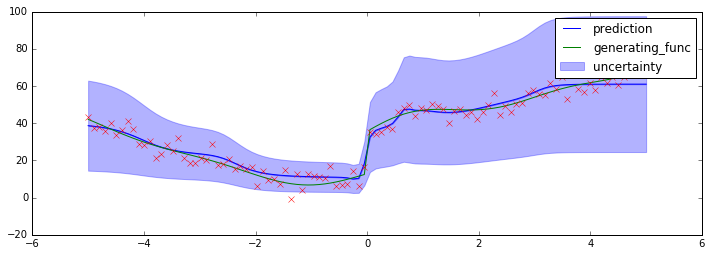

RSME is 4.238579273223877
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 22.363262176513672
COVERAGE/MEAN_VAR is 0.04426903338993705


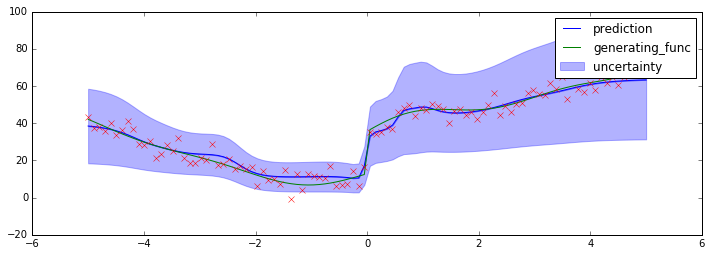

RSME is 3.9933531284332275
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 18.33213233947754
COVERAGE/MEAN_VAR is 0.05400353770456224


RSME is 3.8469252586364746
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.714280128479004
COVERAGE/MEAN_VAR is 0.06728157893935209


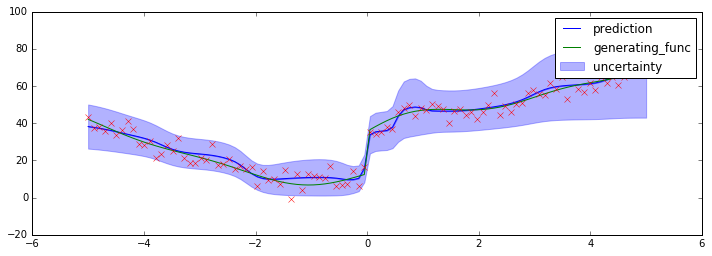

RSME is 3.732205390930176
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 12.209498405456543
COVERAGE/MEAN_VAR is 0.08108441208015224


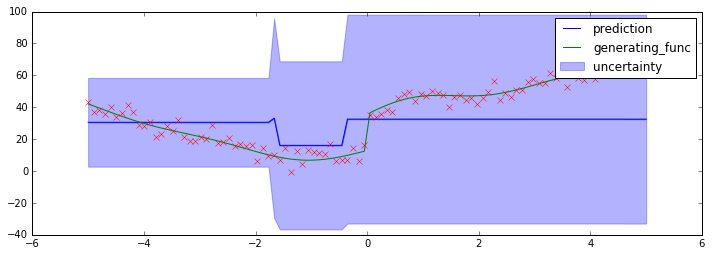

RSME is 17.96794891357422
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 51.5208740234375
COVERAGE/MEAN_VAR is 0.019409608609222882


RSME is 13.65597915649414
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 57.31618118286133
COVERAGE/MEAN_VAR is 0.017447080028057064


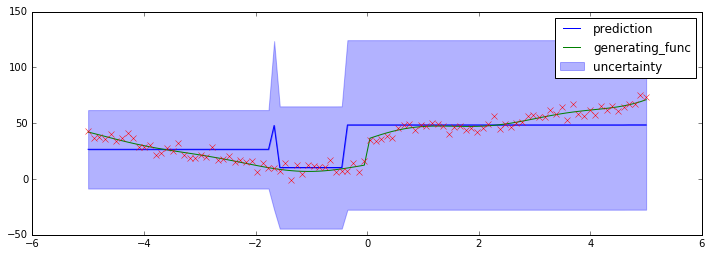

RSME is 12.745271682739258
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 59.95280838012695
COVERAGE/MEAN_VAR is 0.01667978576849251


RSME is 12.113234519958496
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 61.03044891357422
COVERAGE/MEAN_VAR is 0.0163852637134639


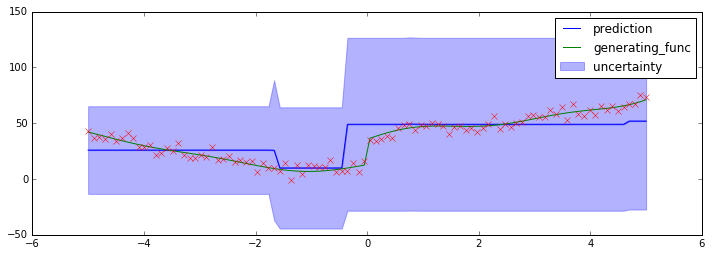

RSME is 12.040801048278809
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 62.01908874511719
COVERAGE/MEAN_VAR is 0.01612406793188703


RSME is 7.812549114227295
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 27.911865234375
COVERAGE/MEAN_VAR is 0.03582705747548698


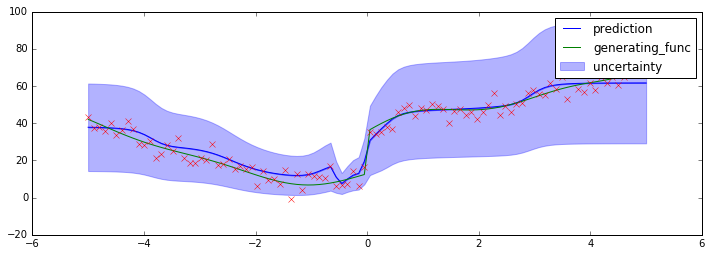

RSME is 4.458385467529297
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 21.88677215576172
COVERAGE/MEAN_VAR is 0.04523280056805367


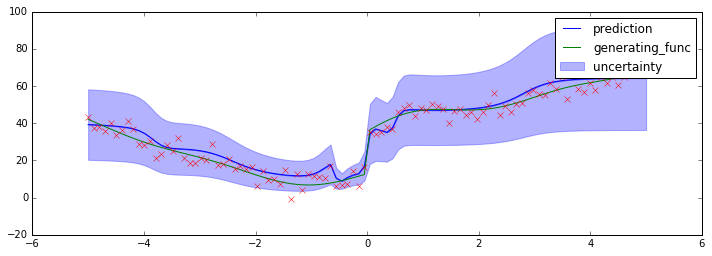

RSME is 4.367745876312256
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 17.396272659301758
COVERAGE/MEAN_VAR is 0.056333906647295255


RSME is 4.128084659576416
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.735133171081543
COVERAGE/MEAN_VAR is 0.07062181253853976


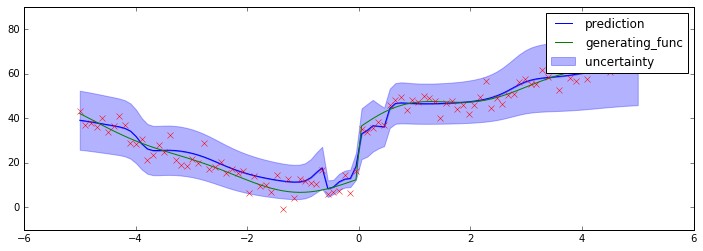

RSME is 3.915639877319336
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 11.15158462524414
COVERAGE/MEAN_VAR is 0.08698315374876724


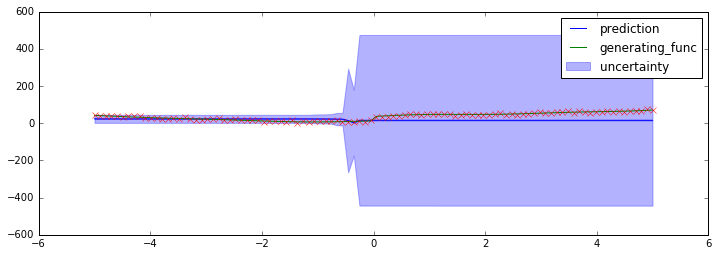

RSME is 28.168779373168945
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 257.8627624511719
COVERAGE/MEAN_VAR is 0.0038392515095601034


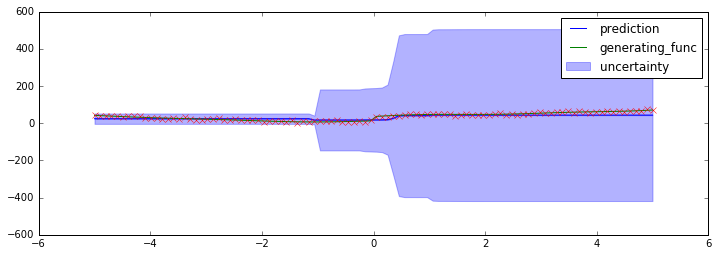

RSME is 12.345027923583984
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 247.04067993164062
COVERAGE/MEAN_VAR is 0.004047916320003301


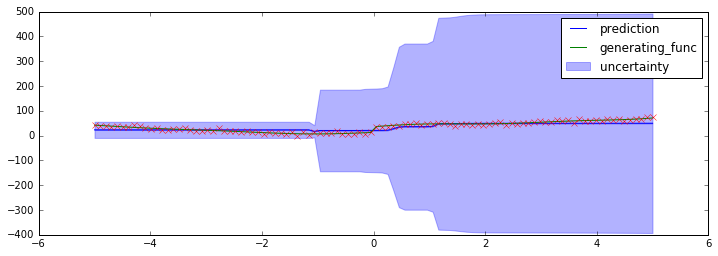

RSME is 10.777068138122559
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 231.84136962890625
COVERAGE/MEAN_VAR is 0.004313294049291705


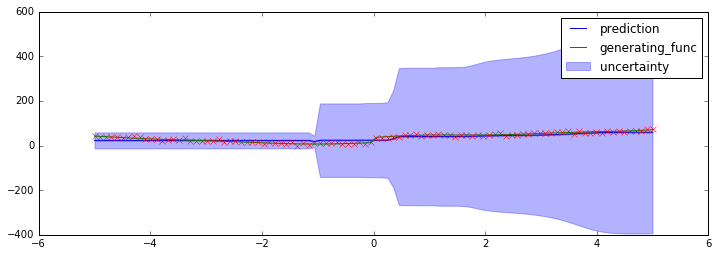

RSME is 9.750176429748535
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 207.67153930664062
COVERAGE/MEAN_VAR is 0.004815296324853809


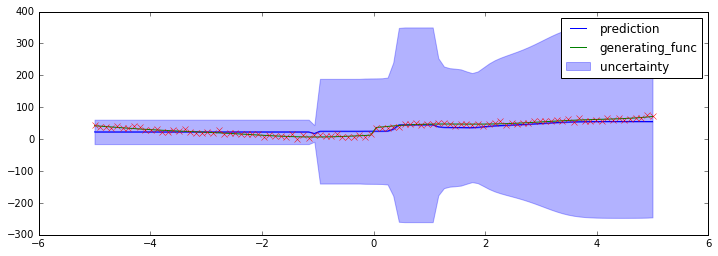

RSME is 10.263625144958496
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 158.49693298339844
COVERAGE/MEAN_VAR is 0.006309270351021516


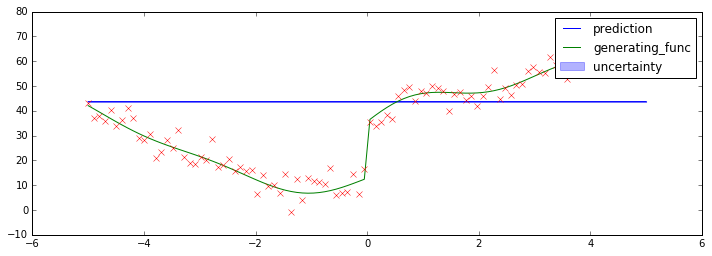

RSME is 20.669837951660156
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 1.7307167824444842e-29
COVERAGE/MEAN_VAR is 0.0


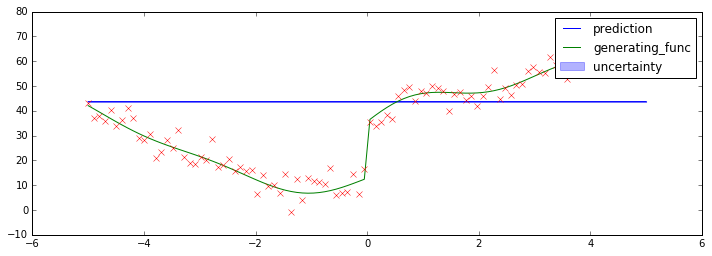

RSME is 20.669836044311523
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 1.7306379396873858e-29
COVERAGE/MEAN_VAR is 0.0


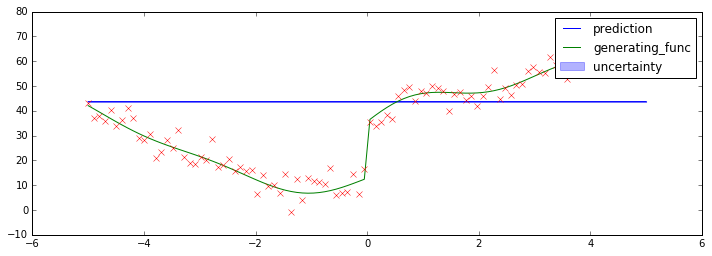

RSME is 20.669830322265625
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 1.7306383910772166e-29
COVERAGE/MEAN_VAR is 0.0


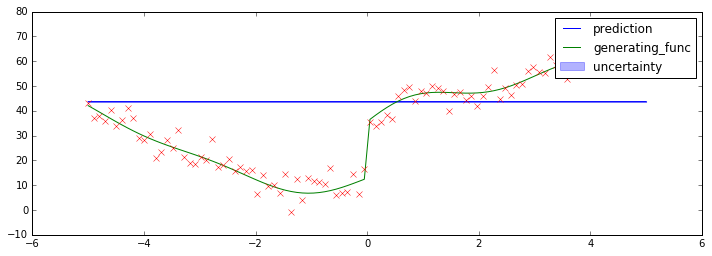

RSME is 20.669830322265625
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 1.730628310037664e-29
COVERAGE/MEAN_VAR is 0.0


RSME is 20.669830322265625
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 1.7306262035517872e-29
COVERAGE/MEAN_VAR is 0.0


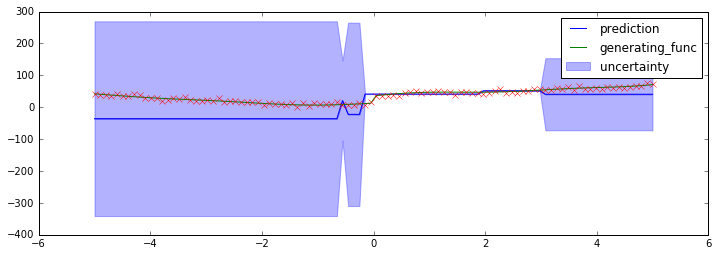

RSME is 40.84065628051758
COVERAGE PROBABILITY is 0.68
MEAN VARIANCE is 166.8885955810547
COVERAGE/MEAN_VAR is 0.004074574404754558


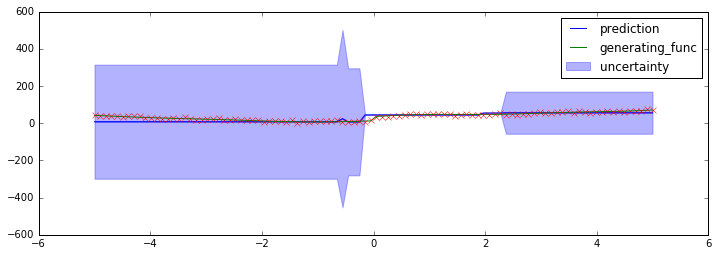

RSME is 13.623483657836914
COVERAGE PROBABILITY is 0.75
MEAN VARIANCE is 178.9330291748047
COVERAGE/MEAN_VAR is 0.0041915123410072265


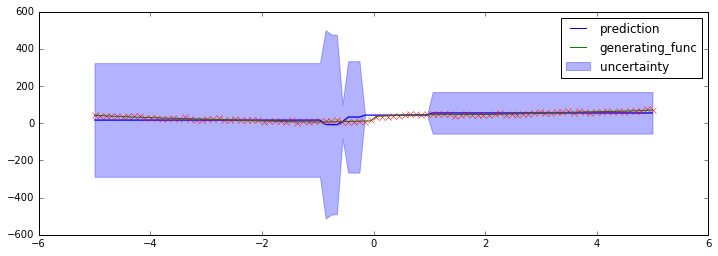

RSME is 12.095451354980469
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 194.7031707763672
COVERAGE/MEAN_VAR is 0.004519700405961819


RSME is 11.710315704345703
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 193.40155029296875
COVERAGE/MEAN_VAR is 0.004550118645207122


RSME is 10.938350677490234
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 185.57626342773438
COVERAGE/MEAN_VAR is 0.004741985767714752


RSME is 14.11340045928955
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 41.301353454589844
COVERAGE/MEAN_VAR is 0.02421228159264765


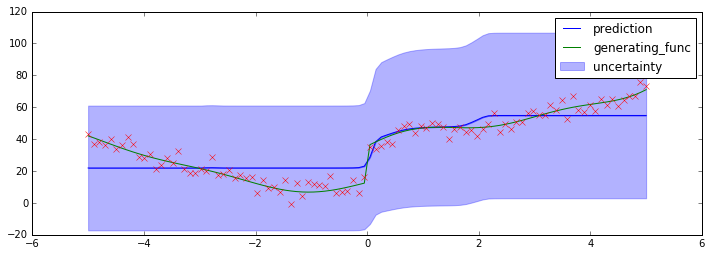

RSME is 9.414226531982422
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 44.84175109863281
COVERAGE/MEAN_VAR is 0.02230064561485176


RSME is 8.773802757263184
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 44.5577392578125
COVERAGE/MEAN_VAR is 0.02244279033579258


RSME is 4.7606987953186035
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 30.95745086669922
COVERAGE/MEAN_VAR is 0.032302401263784135


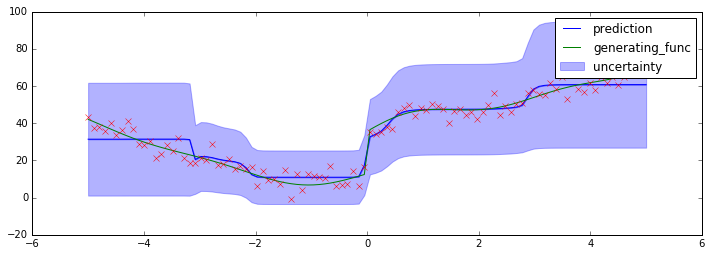

RSME is 4.951955318450928
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 24.630521774291992
COVERAGE/MEAN_VAR is 0.040600033128155084


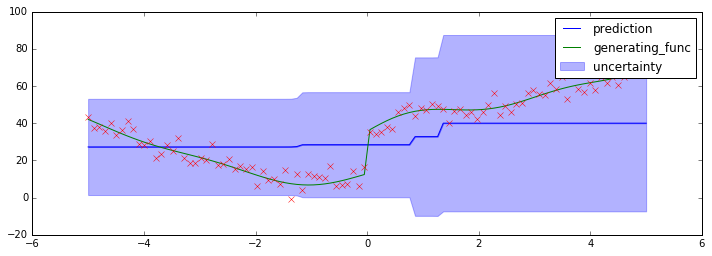

RSME is 15.492624282836914
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 35.15339279174805
COVERAGE/MEAN_VAR is 0.028162288797125547


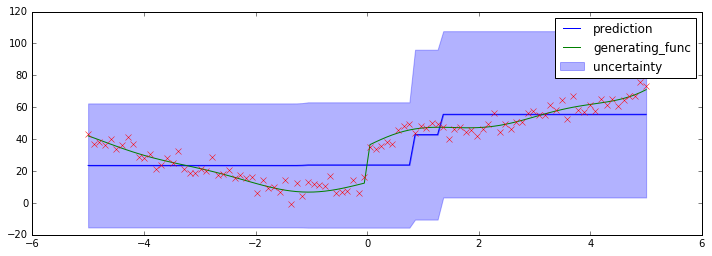

RSME is 11.083327293395996
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 44.60297775268555
COVERAGE/MEAN_VAR is 0.0224200277735894


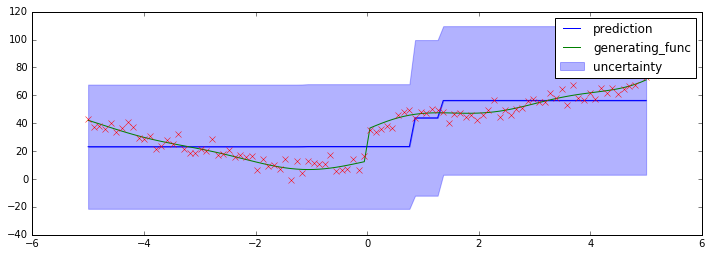

RSME is 11.052916526794434
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 48.34868240356445
COVERAGE/MEAN_VAR is 0.020683086907168254


RSME is 11.011018753051758
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 50.835636138916016
COVERAGE/MEAN_VAR is 0.019671240018859008


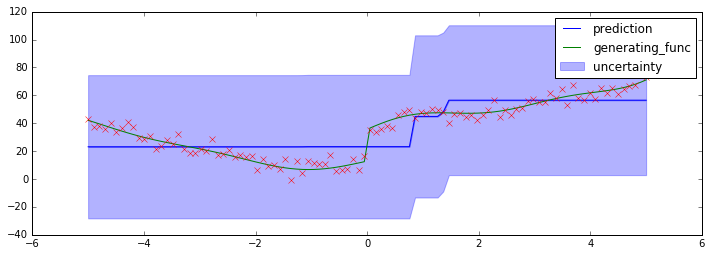

RSME is 11.004623413085938
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 52.61335754394531
COVERAGE/MEAN_VAR is 0.019006580204746482


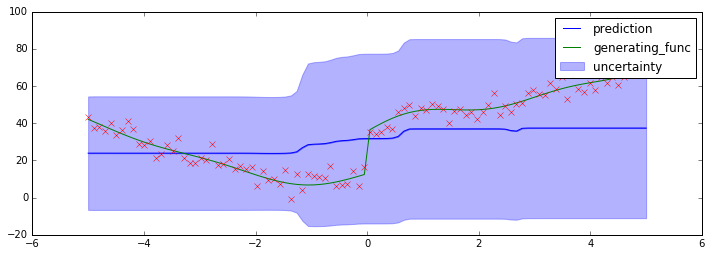

RSME is 16.16915512084961
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 40.947444915771484
COVERAGE/MEAN_VAR is 0.024421548207879413


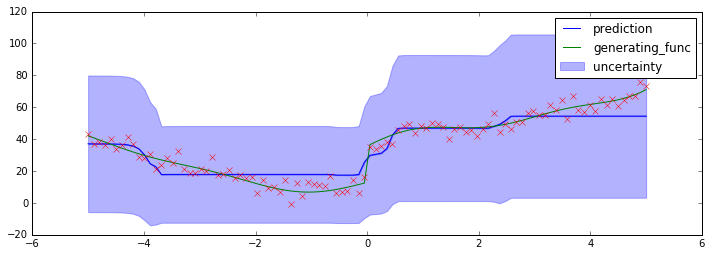

RSME is 6.936072826385498
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 40.69987869262695
COVERAGE/MEAN_VAR is 0.02457009780181867


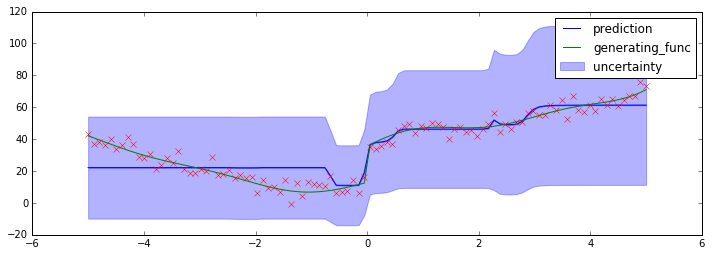

RSME is 7.872742176055908
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 37.05160903930664
COVERAGE/MEAN_VAR is 0.026989381188253878


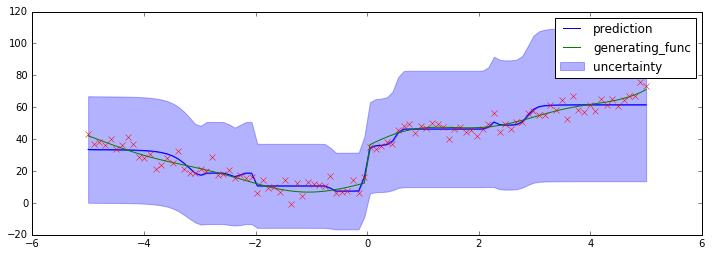

RSME is 4.3954925537109375
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 35.504127502441406
COVERAGE/MEAN_VAR is 0.028165739319498444


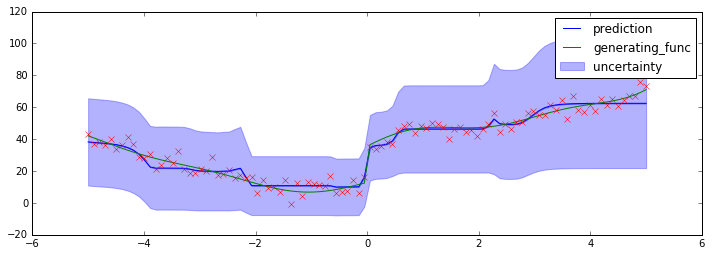

RSME is 4.057095527648926
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 27.884092330932617
COVERAGE/MEAN_VAR is 0.0358627416711955


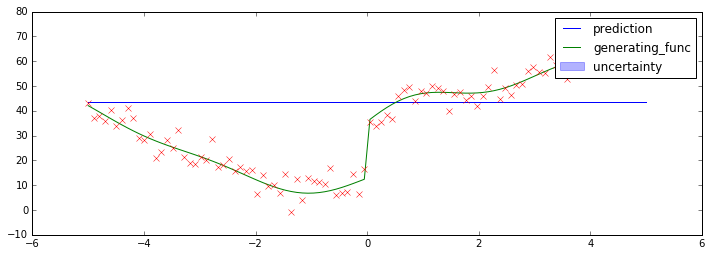

RSME is 20.66759490966797
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 0.0
COVERAGE/MEAN_VAR is nan


/Users/thomas/Documents/Master-Thesis/evaluation.py:30: RuntimeWarning: invalid value encountered in true_divide
  print('COVERAGE/MEAN_VAR is {}'.format(cov_prob * 1.0 / var_mean))


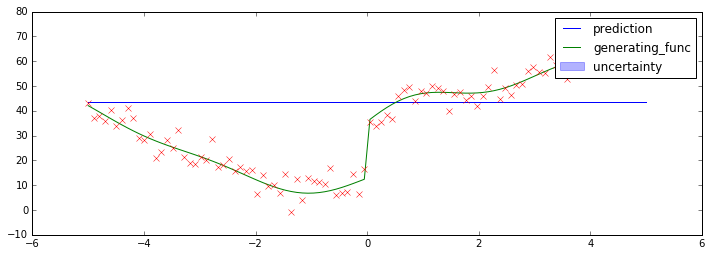

RSME is 20.669830322265625
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 0.0
COVERAGE/MEAN_VAR is nan


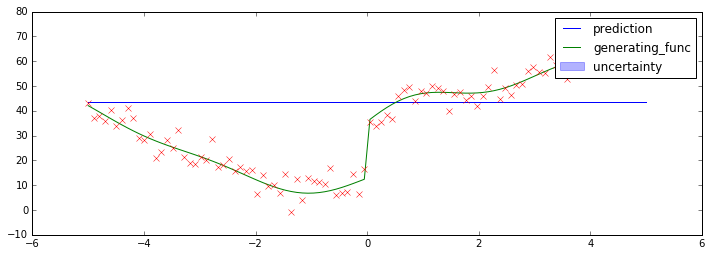

RSME is 20.669828414916992
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 0.0
COVERAGE/MEAN_VAR is nan


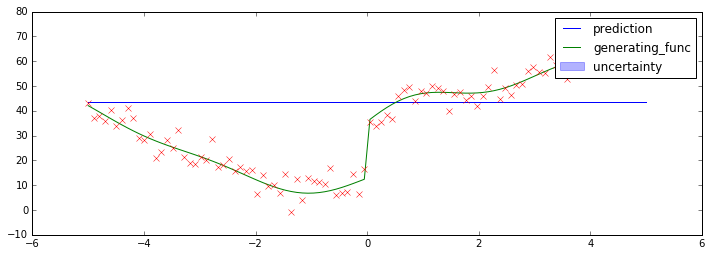

RSME is 20.669830322265625
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 0.0
COVERAGE/MEAN_VAR is nan


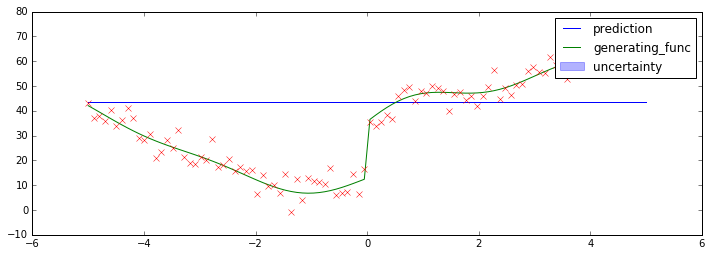

RSME is 20.669830322265625
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 0.0
COVERAGE/MEAN_VAR is nan


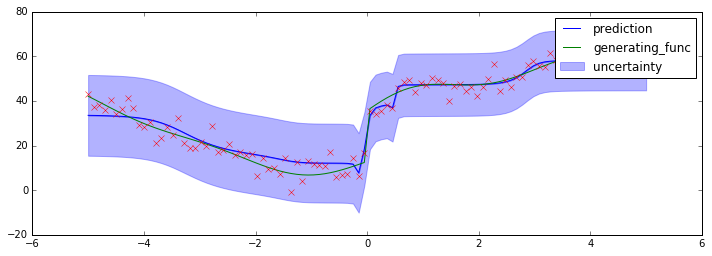

RSME is 5.01104736328125
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 15.847455978393555
COVERAGE/MEAN_VAR is 0.06183957862612986


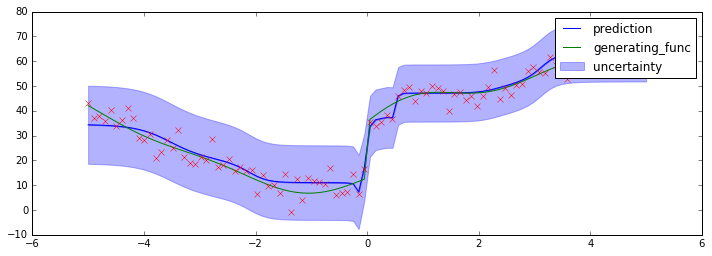

RSME is 4.192560195922852
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 13.416770935058594
COVERAGE/MEAN_VAR is 0.0737882464262014


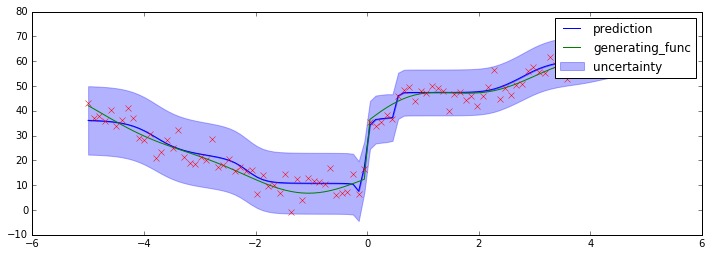

RSME is 3.885169744491577
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 11.191349983215332
COVERAGE/MEAN_VAR is 0.088461177738592


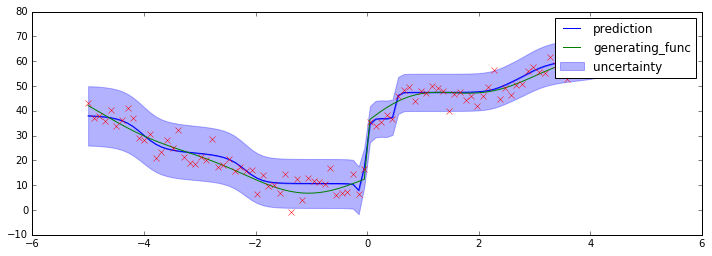

RSME is 3.6758368015289307
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.2588529586792
COVERAGE/MEAN_VAR is 0.10368454972601127


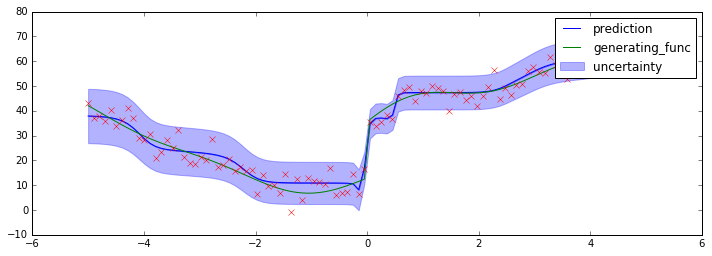

RSME is 3.6520495414733887
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 8.317593574523926
COVERAGE/MEAN_VAR is 0.11662026898874052


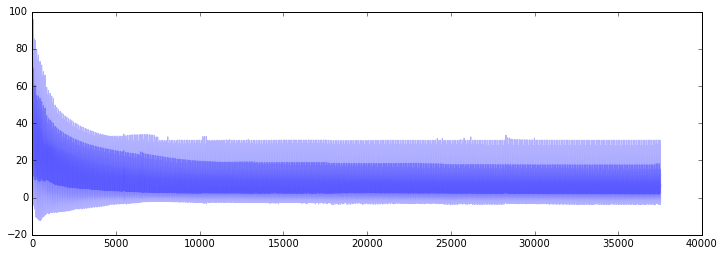

In [23]:
import numpy as np

#num_epochs = 15#10
#num_eps = 25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta_lr = []


bad_seeds = [2,4]
for i in range(n_samples):
    silent = False
    if i == n_samples:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        params['seed'] = seed + 100+i
    lr_tmp = GaussianLearningRateEstimator(**params)

    errors = train_and_plot(lr_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta_lr.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta_lr,axis=0).flatten(),np.std(errors_meta_lr,axis=0).flatten())

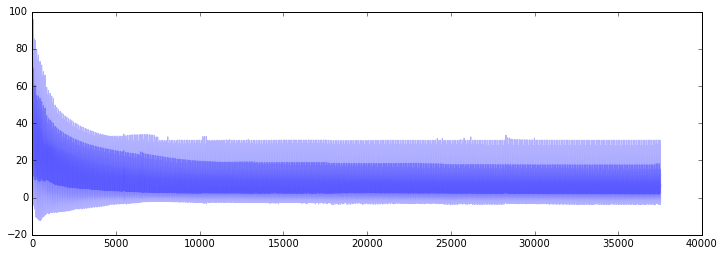

In [24]:
plot_error_tmp(np.mean(errors_meta_lr,axis=0).flatten(),np.std(errors_meta_lr,axis=0).flatten())

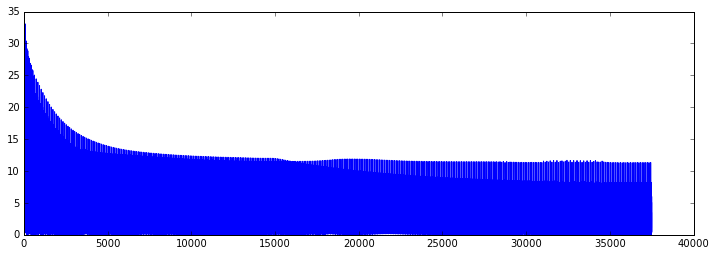

In [25]:
plt.plot(errors_meta_lr[19])

### Example of bad seed
As we can see, the GaussianLossEstimator does not cope well with bad initialisations; as soon as the learning rate is being changed, it seems that (at least for the initialisations that should be equally problematic), the issue disappears. No clue why

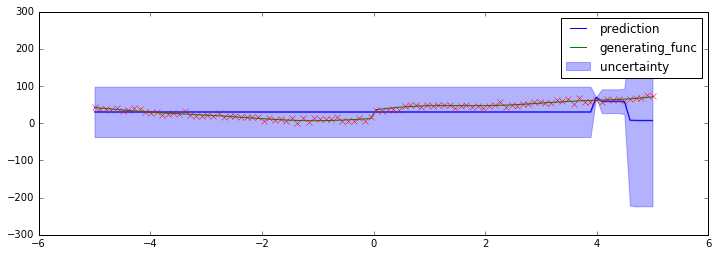

RSME is 21.58622169494629
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 73.4151840209961
COVERAGE/MEAN_VAR is 0.013484948831795733


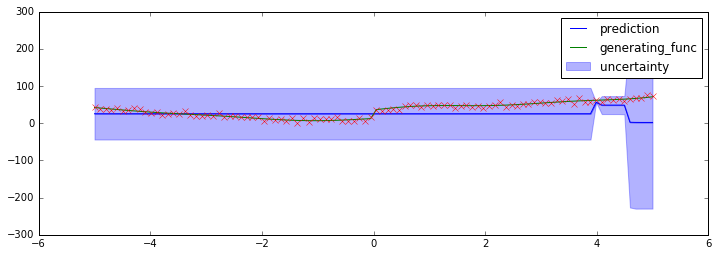

RSME is 23.536792755126953
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 74.46508026123047
COVERAGE/MEAN_VAR is 0.013294822170700512


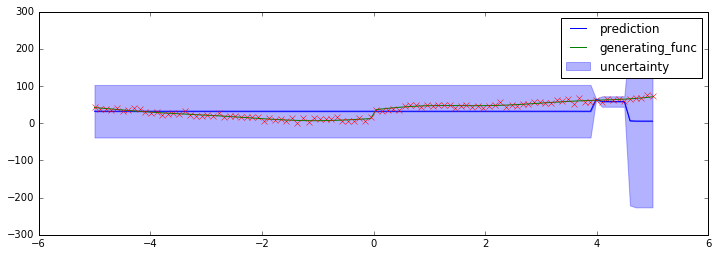

RSME is 21.739229202270508
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 75.15350341796875
COVERAGE/MEAN_VAR is 0.013173038580704368


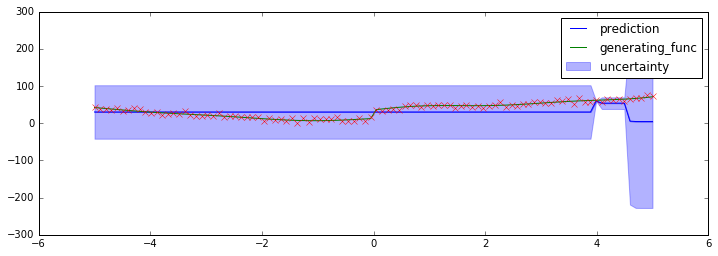

RSME is 22.11310386657715
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 76.30746459960938
COVERAGE/MEAN_VAR is 0.012973829037494555


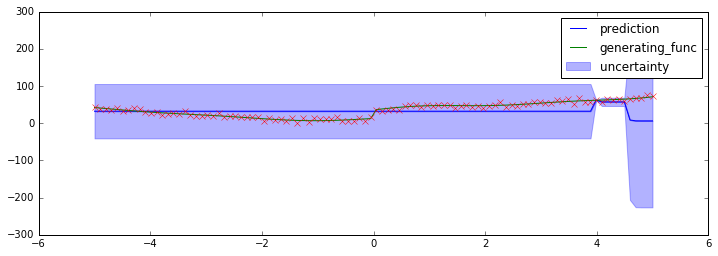

RSME is 21.623355865478516
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 77.03616333007812
COVERAGE/MEAN_VAR is 0.012851107287860776


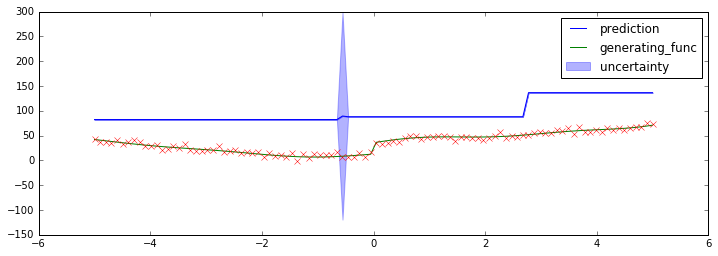

RSME is 62.104637145996094
COVERAGE PROBABILITY is 0.01
MEAN VARIANCE is 2.088183879852295
COVERAGE/MEAN_VAR is 0.00478885030024623


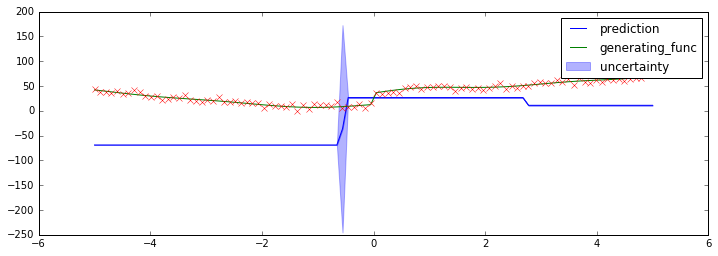

RSME is 66.22119903564453
COVERAGE PROBABILITY is 0.01
MEAN VARIANCE is 2.089315891265869
COVERAGE/MEAN_VAR is 0.0047862556551662595


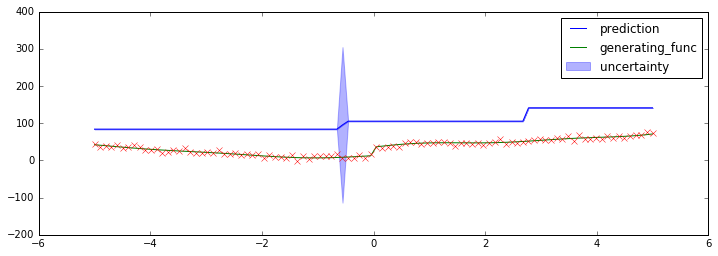

RSME is 69.04349517822266
COVERAGE PROBABILITY is 0.01
MEAN VARIANCE is 2.0903007984161377
COVERAGE/MEAN_VAR is 0.004784000469012497


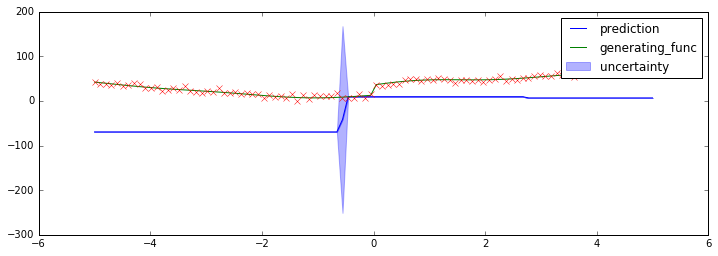

RSME is 69.18577575683594
COVERAGE PROBABILITY is 0.01
MEAN VARIANCE is 2.0911872386932373
COVERAGE/MEAN_VAR is 0.004781972563226287


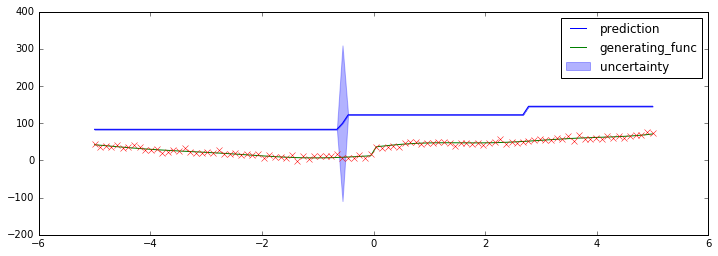

RSME is 75.58518981933594
COVERAGE PROBABILITY is 0.01
MEAN VARIANCE is 2.09201717376709
COVERAGE/MEAN_VAR is 0.004780075481881933


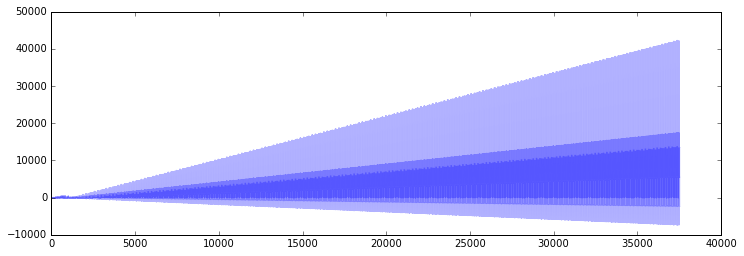

In [26]:
import numpy as np
n_samples = 3
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


#bad_seeds = [2,4,10,13,15,16,9]
#very_bad_seeds = [16,10]
bad_seeds = [1,3]#ignoring the good seeds
very_bad_seeds = []
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp = GaussianLossEstimator(**params)

    errors = train_and_plot(gauss_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

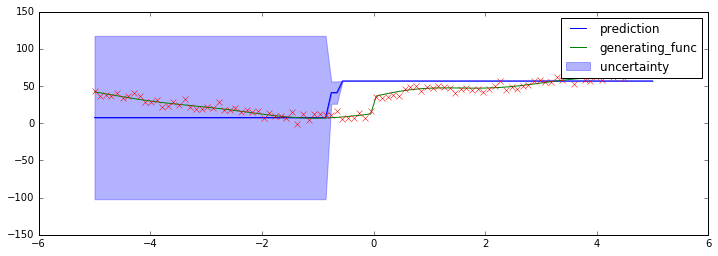

RSME is 18.59352684020996
COVERAGE PROBABILITY is 0.42
MEAN VARIANCE is 46.42860794067383
COVERAGE/MEAN_VAR is 0.009046146732132767


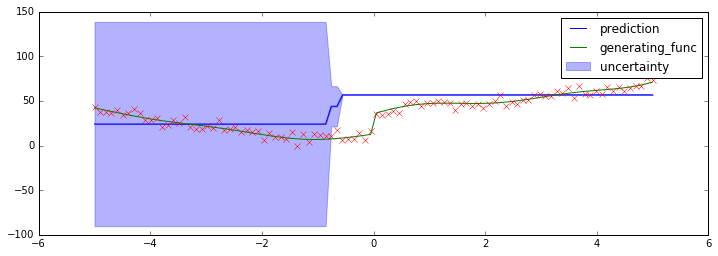

RSME is 16.238853454589844
COVERAGE PROBABILITY is 0.42
MEAN VARIANCE is 48.48971176147461
COVERAGE/MEAN_VAR is 0.008661631194386532


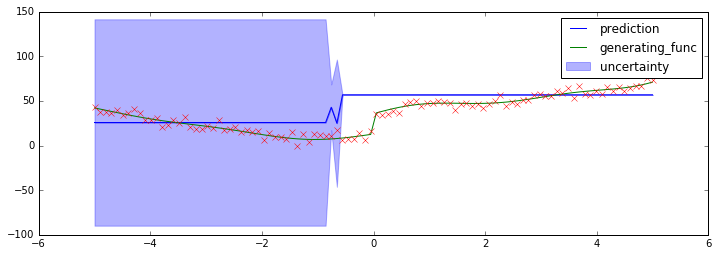

RSME is 16.13977813720703
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 49.514556884765625
COVERAGE/MEAN_VAR is 0.008684314816766544


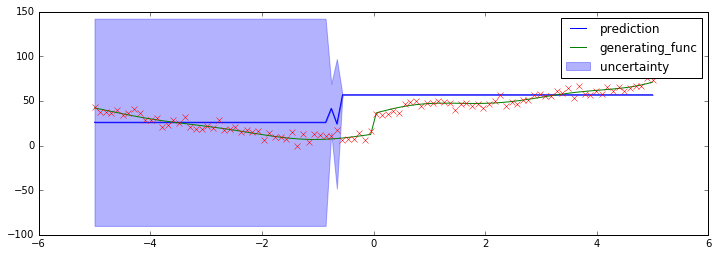

RSME is 16.13401985168457
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 49.7471809387207
COVERAGE/MEAN_VAR is 0.008643705872091128


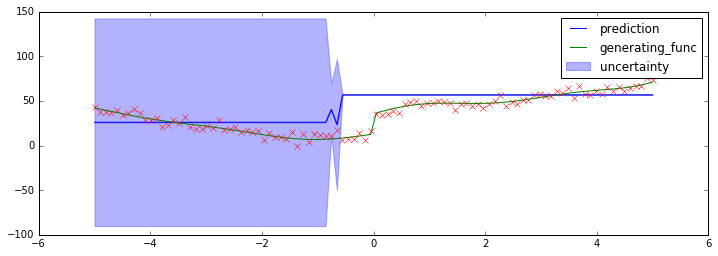

RSME is 16.11505699157715
COVERAGE PROBABILITY is 0.43
MEAN VARIANCE is 49.860939025878906
COVERAGE/MEAN_VAR is 0.008623985195642237


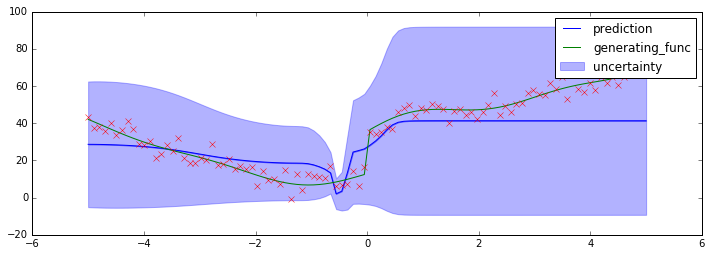

RSME is 12.007190704345703
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 37.3979377746582
COVERAGE/MEAN_VAR is 0.02673944231966784


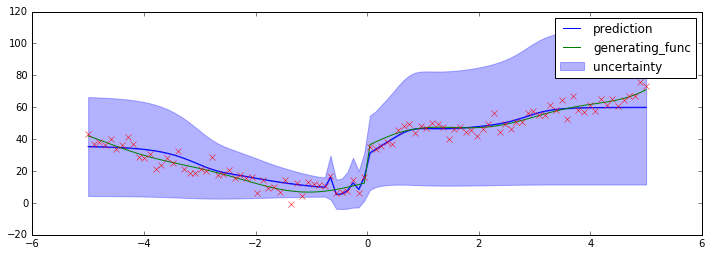

RSME is 4.6698455810546875
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 29.525283813476562
COVERAGE/MEAN_VAR is 0.03353058369410569


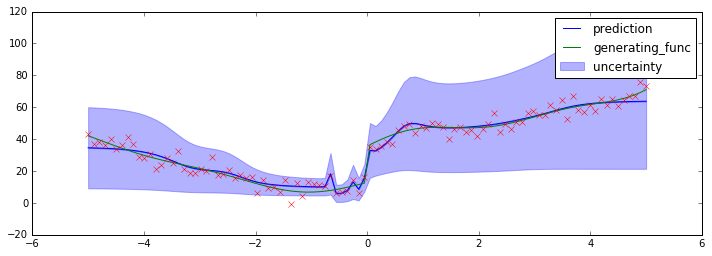

RSME is 4.005434989929199
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 23.149099349975586
COVERAGE/MEAN_VAR is 0.04233426040400287


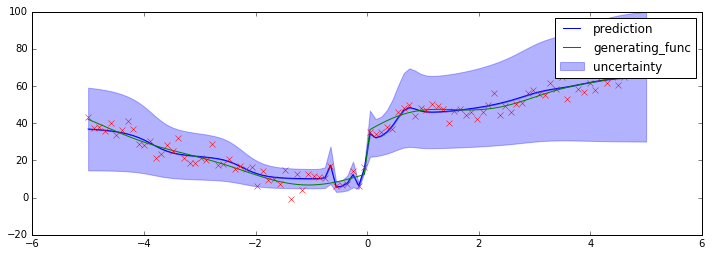

RSME is 3.7495031356811523
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 17.778644561767578
COVERAGE/MEAN_VAR is 0.05512231242349372


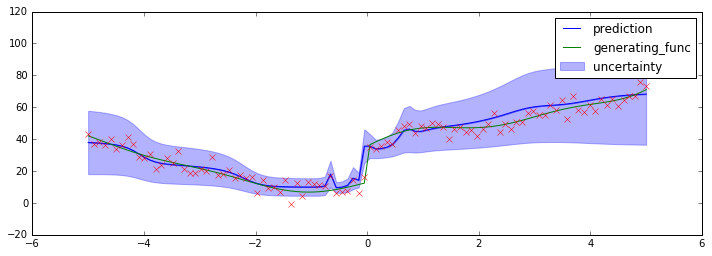

RSME is 4.772465229034424
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 15.028425216674805
COVERAGE/MEAN_VAR is 0.0632135427566906


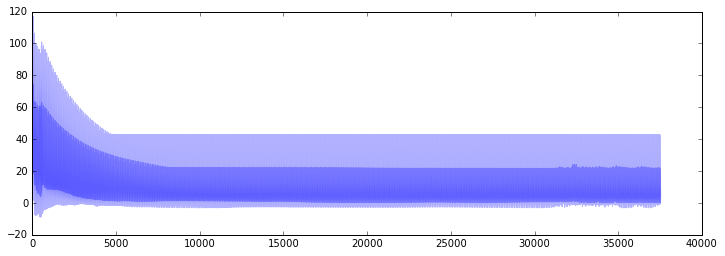

In [27]:
import numpy as np
n_samples = 3
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


#bad_seeds = [2,4,10,13,15,16,9]
#very_bad_seeds = [16,10]
bad_seeds = [1,3]#ignoring the good seeds
very_bad_seeds = []
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp_lr = GaussianLearningRateEstimator(**params)

    errors = train_and_plot(gauss_tmp_lr,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

# Old Stuff can probbly be removed only staying for security reasons

In [28]:
gauss.train(X,y)
gauss_lr.train(X,y)
vanilla.train(X,y)

In [29]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)

lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

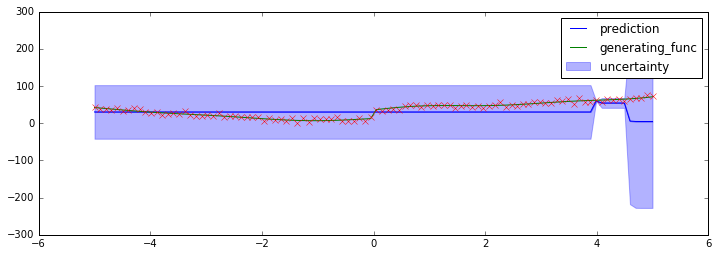

In [30]:
plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

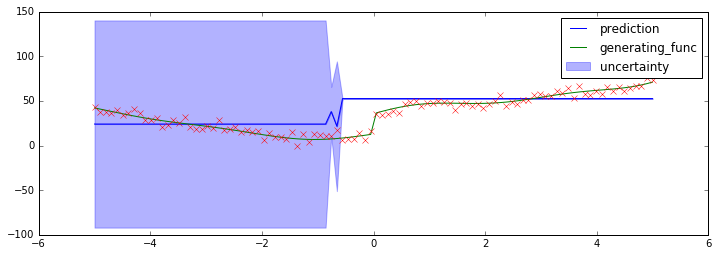

In [31]:
plot_prediction(X,lr_preds,sorted_index,lr_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

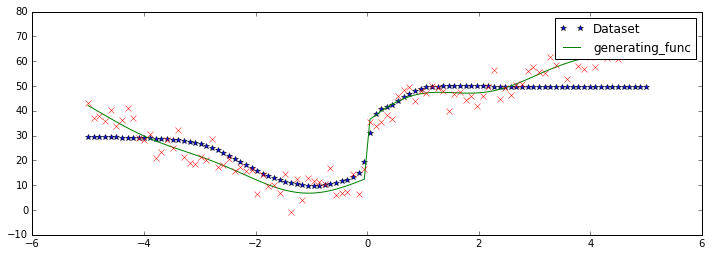

In [32]:
plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [33]:
evaluate_model(X,y,gauss_preds,var=gauss_var)

RSME is 22.070514678955078
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 76.31519317626953
COVERAGE/MEAN_VAR is 0.012972515154529463


In [34]:
evaluate_model(X,y,lr_preds,var=lr_var)

RSME is 14.892871856689453
COVERAGE PROBABILITY is 0.44
MEAN VARIANCE is 49.73506164550781
COVERAGE/MEAN_VAR is 0.008846877543575778


In [35]:
evaluate_model(X,y,vanilla_preds)

RSME is 7.920229434967041


# Other research
https://arxiv.org/pdf/1406.2541.pdf

https://arxiv.org/pdf/1612.01474.pdf